#**Predicting House Prices in Ames, Iowa: A Comprehensive Regression Project**

#**The Business Problem**

Predicting house prices is a critical task with significant real-world applications for buyers, sellers, real estate agents, and financial institutions. An accurate model can help sellers price their homes competitively, allow buyers to make informed decisions, and assist agents in valuing properties. This project aims to tackle this classic regression problem by building a robust machine learning model that can accurately estimate the final sale price of a house based on a wide array of its features helping both buyer and sellers have a idea about the approximate valuation of their property.

<br>

#**The Dataset: Ames Housing**

To achieve this goal, we will be using the well-known Ames Housing dataset.
The challenge in our dataset is complexity, not scale. This is far more representative of real-world business problems where we have a lot of detailed information about each customer or transaction.

<br>

**This dataset is an ideal choice for a portfolio project as it mirrors the complexity of real-world data, featuring:**

**High Dimensionality:** With 79 explanatory variables (features), it provides a rich, multi-faceted description of each property.

**Mixed Data Types:** The features are a mix of numerical (e.g., GrLivArea - living area in square feet) and categorical (e.g., Neighborhood, KitchenQual) data.

**Data Quality Challenges:** The dataset contains a significant number of missing values across various columns, requiring an intelligent and strategic imputation strategy.

Successfully identifying and navigating these complexities will demonstrate a comprehensive and professional data science workflow.

<br>

#**Project Goal and Success Metric**

The primary technical objective is to build and optimize a regression model that can predict the SalePrice of a house with the highest possible accuracy.

**Our main success metric will be the Root Mean Squared Error (RMSE).** RMSE measures the average difference between the model's predicted prices and the actual sale prices, expressed in dollars. A lower RMSE indicates a more accurate model. Our goal is to minimize this value on a final, unseen test set.


<br>

#**Project Workflow**

This notebook will follow a structured, end-to-end machine learning process:

**Exploratory Data Analysis (EDA):** We will start by deeply analyzing the target variable (SalePrice) and identifying the key numerical and categorical features that are the strongest drivers of house prices.

**Data Cleaning & Imputation:** A comprehensive strategy will be developed to handle the extensive missing values in the dataset.

**Feature Engineering:** We will create new, more powerful features from the existing data to improve our model's predictive power.

**Preprocessing & Modeling:** A robust Scikit-learn Pipeline will be built to handle data scaling and encoding consistently. We will then train and evaluate several models, from a simple LinearRegression baseline to more complex ensembles like RandomForest and XGBoost.

**Hyperparameter Tuning:** The most promising models will be optimized using GridSearchCV to find their best settings and maximize performance.

**Final Evaluation & Interpretation:** The champion model will be selected based on its performance on the unseen test set. We will conclude by visualizing its performance and interpreting its feature importances to provide clear, data-driven insights into what makes a house in Ames valuable.

**Scope for further extension:** The final trained model could be used for deployment using Streamlit or other similar services.

In [48]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

# --- 1. Fetch the Ames Housing dataset from OpenML ---")
housing = fetch_openml(name="house_prices", as_frame=True)

# The features are in 'housing.data' and the target is in 'housing.target'.
# We will combine them into a single DataFrame for ease of use.
df = pd.concat([housing.data, housing.target], axis=1)

# Lets rename the target column to 'SalePrice'
df.rename(columns={'target': 'SalePrice'}, inplace=True)

print("Dataset loaded successfully!")


# --- 2. Initial Inspection ---

print("\n--- First 5 Rows ---")
display(df.head())

Dataset loaded successfully!

--- First 5 Rows ---


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Let's check the number of total rows in our dataset.
df.shape

(1460, 81)

**We should now get to know our target feature through Visualization**

--- Statistical Summary for SalePrice ---
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


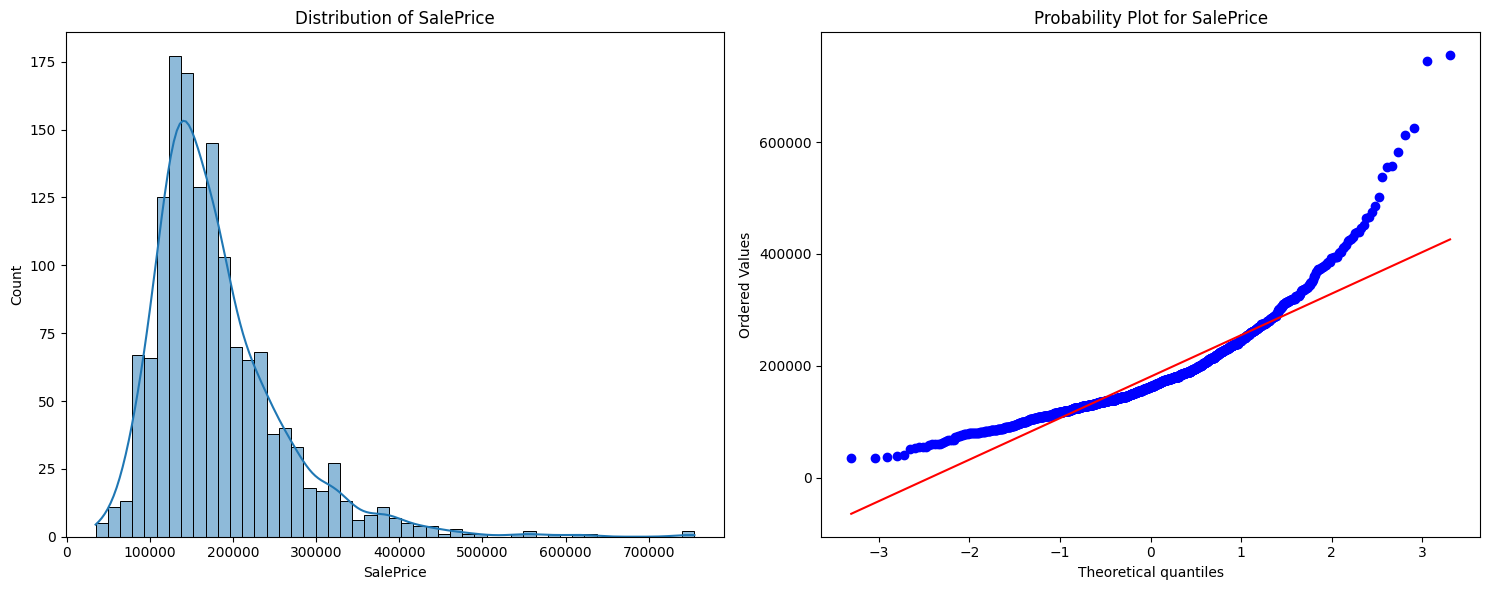

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# --- 1. Statistical Summary ---
print("--- Statistical Summary for SalePrice ---")
print(df['SalePrice'].describe())


# --- 2. Visualizations ---
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot 1: Histogram and KDE plot to see the distribution shape
sns.histplot(df['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of SalePrice')

# Plot 2: A probability plot (QQ plot) to check for normality
# If the data is normal, the dots will follow the straight red line.
stats.probplot(df['SalePrice'], plot=axes[1])
axes[1].set_title('Probability Plot for SalePrice')

plt.tight_layout()
plt.show()

**Observations:**
1. We observed Positive Skewness or a Right-Skewed Distribution in our target feature. It means that while most houses are clustered around the lower-to-middle price range, there are a few houses that are exceptionally expensive, pulling the average price up and creating that long tail.

2. Our QQ plot or probability plot shows the distribution of one variable, not a relationship between two. We observe a curved line showing a Deviation from Normality. The plot compares the distribution of our SalePrice to a perfect theoretical normal distribution (the red line). The fact that the blue dots curve away from the red line is definitive proof that our data is not normally distributed.

**Analysis:**
1. Many regression models, especially linear models, work best when the target variable is normally distributed. A heavily skewed target variable like ours can cause several problems:

2. Biased Predictions: The model can become very good at predicting the prices of "average" houses but will be terrible at predicting the prices of the very expensive houses in the long tail.

3. Violated Assumptions: It violates the assumptions of linear regression, leading to less reliable results.

**Using Logarithmic Transformation to deal with Positive skewness.**
The standard and most effective way to correct for positive skewness is to apply a logarithmic transformation. This mathematical function has the effect of "squishing" the long tail and pulling the entire distribution closer to a symmetrical, bell-like shape.

We will use **np.log1p**, which calculates **log(1 + x)**. It's a safer version of log(x) because it handles potential zero values without errors.

**Why using log(1+x) instead of log(x)?**

When applying a log transformation to any data that could potentially contain a zero (like many features in the Ames dataset, e.g., PoolArea or TotalBsmtSF), always use np.log1p() for the transformation and np.expm1() for the inverse. It is the safe, professional, and robust choice.

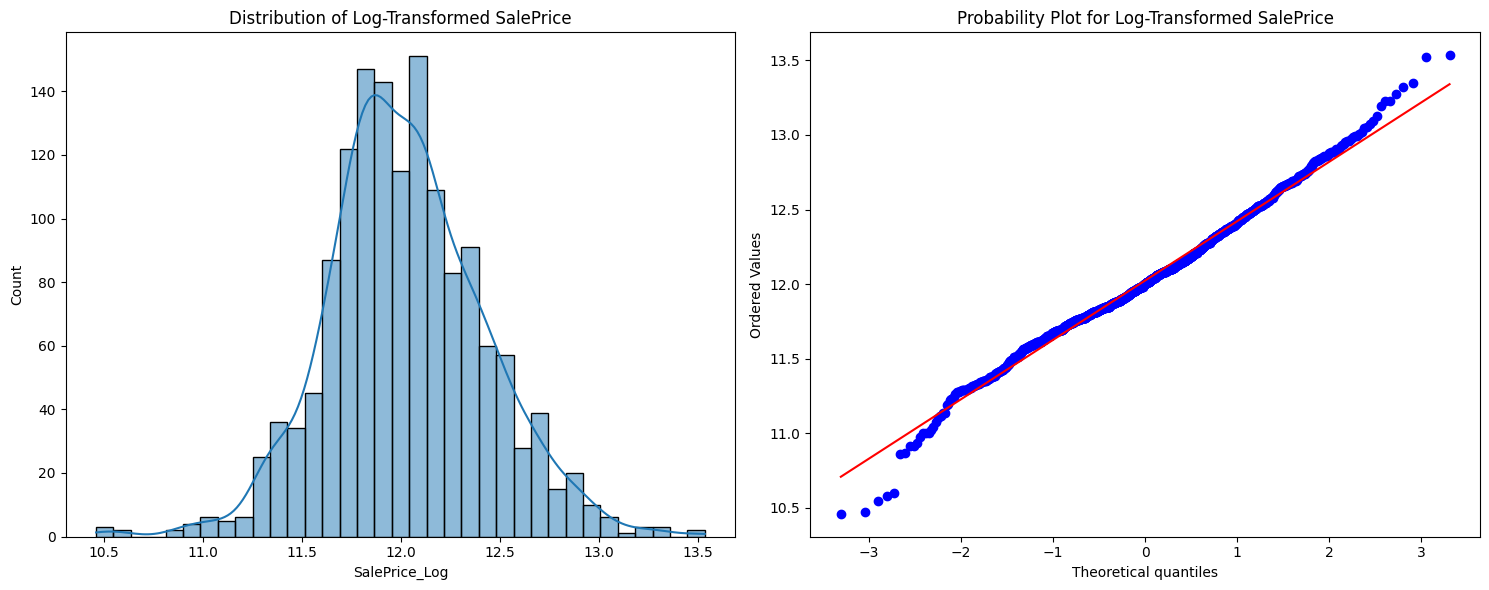

In [6]:
import numpy as np

# --- 1. Apply the log transformation to the SalePrice ---
# We use np.log1p which is log(1+x) to handle any potential zero values gracefully
df['SalePrice_Log'] = np.log1p(df['SalePrice'])

# --- 2. Visualize the TRANSFORMED data ---
# Create a new figure to compare the before and after
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot 1: Histogram and KDE plot of the new log-transformed SalePrice
sns.histplot(df['SalePrice_Log'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Log-Transformed SalePrice')

# Plot 2: A probability plot of the new log-transformed SalePrice
stats.probplot(df['SalePrice_Log'], plot=axes[1])
axes[1].set_title('Probability Plot for Log-Transformed SalePrice')

plt.tight_layout()
plt.show()

**Do we need both SalePrice and SalePrice_Log?**

* SalePrice_Log is the technical language that the model understands best.

* SalePrice is the human language (dollars) that we and the business understand.

**1. Role of SalePrice_Log (The Model's Target)**
Its purpose is to be the clean, well-behaved, normally distributed target variable that we train our model on.

As we know, the original SalePrice was skewed. By training our model to predict the log-transformed value, we are the results more reliable, especially for linear models. It helps the model learn the underlying patterns more effectively without being biased by the few extremely expensive houses.

**2. Role of SalePrice (The Business Target)**
Its Purpose is to evaluate the model's performance in a real-world, understandable way and to present the final results and it is used in the EDA stage of the project as well.

No one in the real world cares about the "log of the price." People need a prediction in dollars. To know if our model is good, we need to answer the question: "On average, how many dollars off is our prediction?" We can only answer this by comparing our final dollar predictions to the original dollar prices.


#**Basic EDA**

#Visualisaing numerical features

**Finding the Most Correlated Features**

/tmp/ipython-input-531558974.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='viridis')


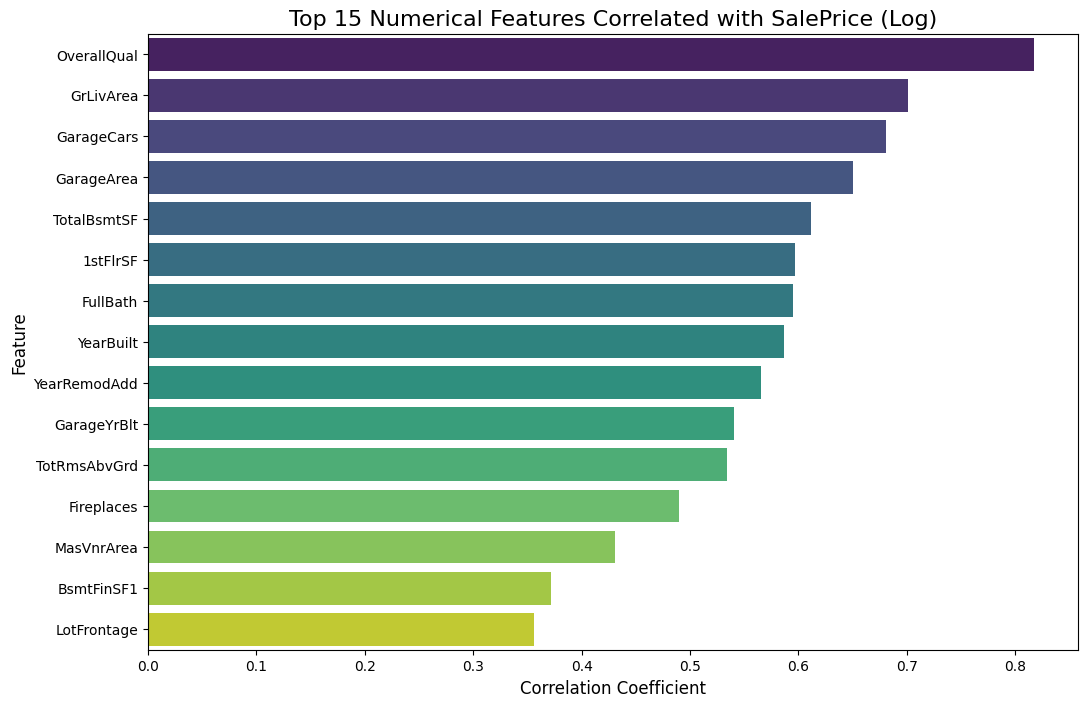

--- Top 15 Most Correlated Numerical Features ---
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489450
MasVnrArea      0.430809
BsmtFinSF1      0.372023
LotFrontage     0.355879
Name: SalePrice_Log, dtype: float64


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Calculate the correlation of all numerical features with our new target ---
# We select only columns with numerical data types for this calculation
numeric_features = df.select_dtypes(include=np.number)
correlation_matrix = numeric_features.corr()

# Get the correlation values for 'SalePrice_Log' and sort them
sale_price_corr = correlation_matrix['SalePrice_Log'].sort_values(ascending=False)

# --- 2. Visualize the top correlated features ---
# We'll plot the top 15 features (excluding 'SalePrice_Log' itself, which is 1.0)
top_corr_features = sale_price_corr.drop(['SalePrice_Log', 'SalePrice']).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='viridis')
plt.title('Top 15 Numerical Features Correlated with SalePrice (Log)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# --- 3. Print the exact correlation values ---
print("--- Top 15 Most Correlated Numerical Features ---")
print(top_corr_features)

#Visualising the top 2 numerical features:

/tmp/ipython-input-3941134510.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OverallQual', y='SalePrice_Log', data=df, ax=axes[1], palette='coolwarm')


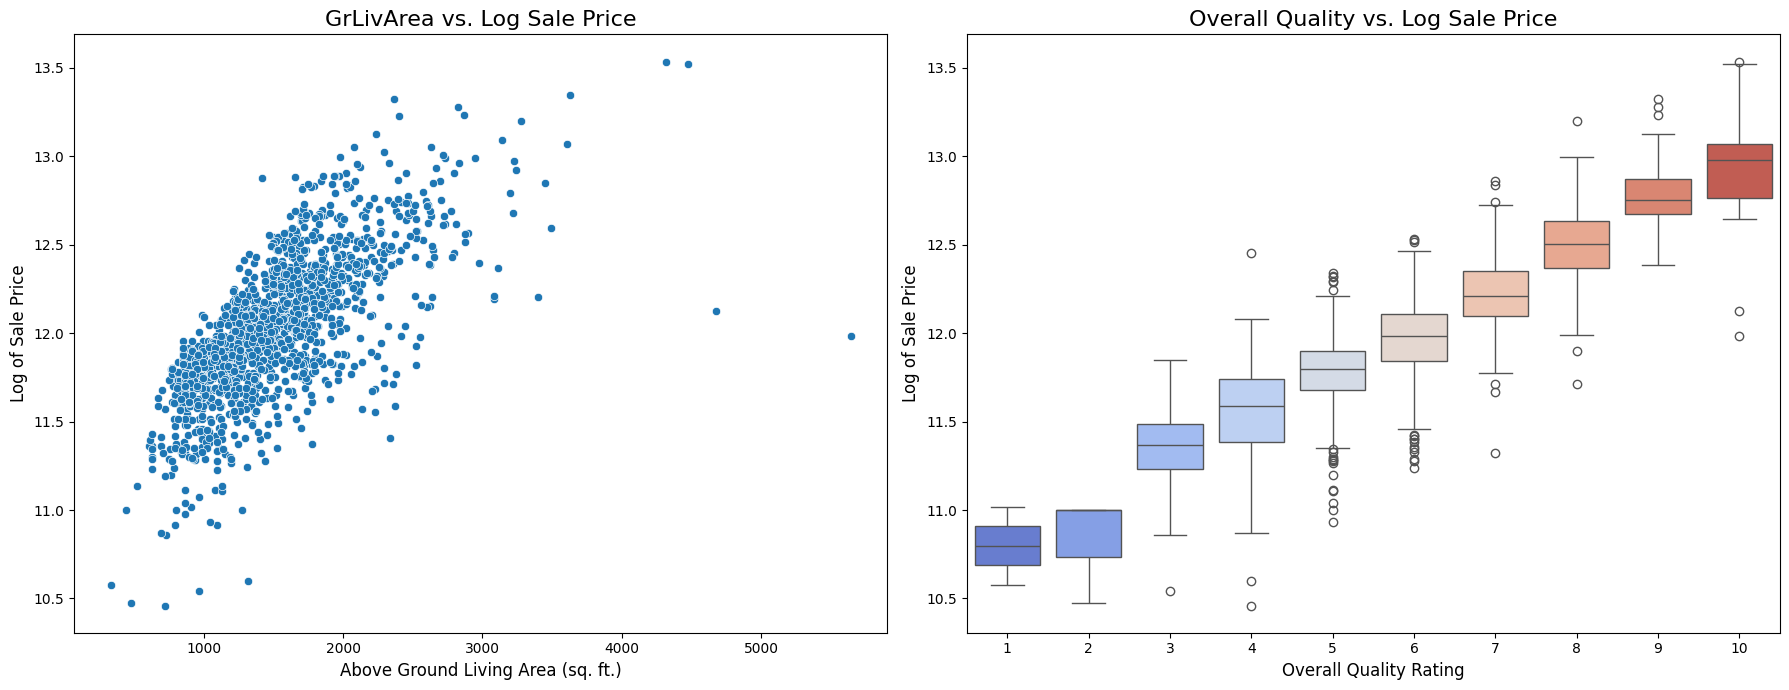

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Create a figure with two subplots ---
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# --- Plot 1: Scatter plot for GrLivArea vs. SalePrice_Log ---
# This is a classic relationship: size vs. price.
sns.scatterplot(x='GrLivArea', y='SalePrice_Log', data=df, ax=axes[0])
axes[0].set_title('GrLivArea vs. Log Sale Price', fontsize=16)
axes[0].set_xlabel('Above Ground Living Area (sq. ft.)', fontsize=12)
axes[0].set_ylabel('Log of Sale Price', fontsize=12)

# --- Plot 2: Box plot for OverallQual vs. SalePrice_Log ---
# OverallQual is an ordinal feature (rated 1-10), so a box plot is
# an excellent way to see how each quality level affects the price distribution.
sns.boxplot(x='OverallQual', y='SalePrice_Log', data=df, ax=axes[1], palette='coolwarm')
axes[1].set_title('Overall Quality vs. Log Sale Price', fontsize=16)
axes[1].set_xlabel('Overall Quality Rating', fontsize=12)
axes[1].set_ylabel('Log of Sale Price', fontsize=12)

plt.tight_layout()
plt.show()

**Why different types of plots for different features?**

The reason is that GrLivArea and OverallQual are two different types of numerical features, and we must choose the best visualization tool for each job.

* GrLivArea is a continuous feature.

 It can have many unique values (e.g., 1500 sq ft, 1501.5 sq ft, etc.). The best way to visualize the relationship between two continuous variables is a scatterplot.

* OverallQual is an ordinal feature.

 Although it uses numbers (1-10), it represents distinct, ordered categories. A house is rated a '7' or an '8', never a '7.5'. The best way to compare a continuous variable (SalePrice_Log) across several distinct categories is a boxplot.

**Interpreting the scatter plot:**

This visually confirms a strong positive correlation. As the living area (GrLivArea) increases, the SalePrice also clearly tends to increase.

We obeserve that instead of forming a perfect, thin line, the plot has a "cluster" or "cloud" of points showing the general trend. The fact that the cloud has a clear direction is what tells us the relationship is strong and can be approximated by a line.

There are some outliers present. This is a critical insight. These represent that there are some very large houses (over 4000 sq ft) that sold for an unusually low price. These are significant outliers. A real estate expert might guess these were foreclosures or had severe structural issues. For our model, these outliers could be problematic. They might confuse the model, so it's a common practice to remove such clear, influential outliers during the data cleaning phase.

**Interpreting the box plot**

We can see gradually increases towards top right showing a very strong positive monotonic relationship. As the OverallQual rating increases, the median SalePrice (the line in the box) also consistently and predictably increases. This is one of the strongest and most reliable predictive features in the entire dataset. The relationship is so clear it's almost a perfect staircase.

Boxes get taller for higher quality ratings. This means there is more price variability for high-quality homes than for low-quality homes. The price for a '9' rated house can vary a lot, while the price for a '3' rated house is much more tightly clustered.

We can see a few dots above the boxes for some of the quality ratings. These represent houses that sold for an unusually high price even for their quality category. These are potential outliers.

**Conclusion:**
By creating these two different plots, we have successfully confirmed the importance of our top two features and gained a much deeper understanding of their relationship with SalePrice. We've confirmed the linear trend for GrLivArea, discovered potential outliers to handle, and seen the powerful, stepwise relationship of OverallQual.

#Visualising the top 6 features using pairplots.

Generating a pair plot for the top 6 numerical predictors...


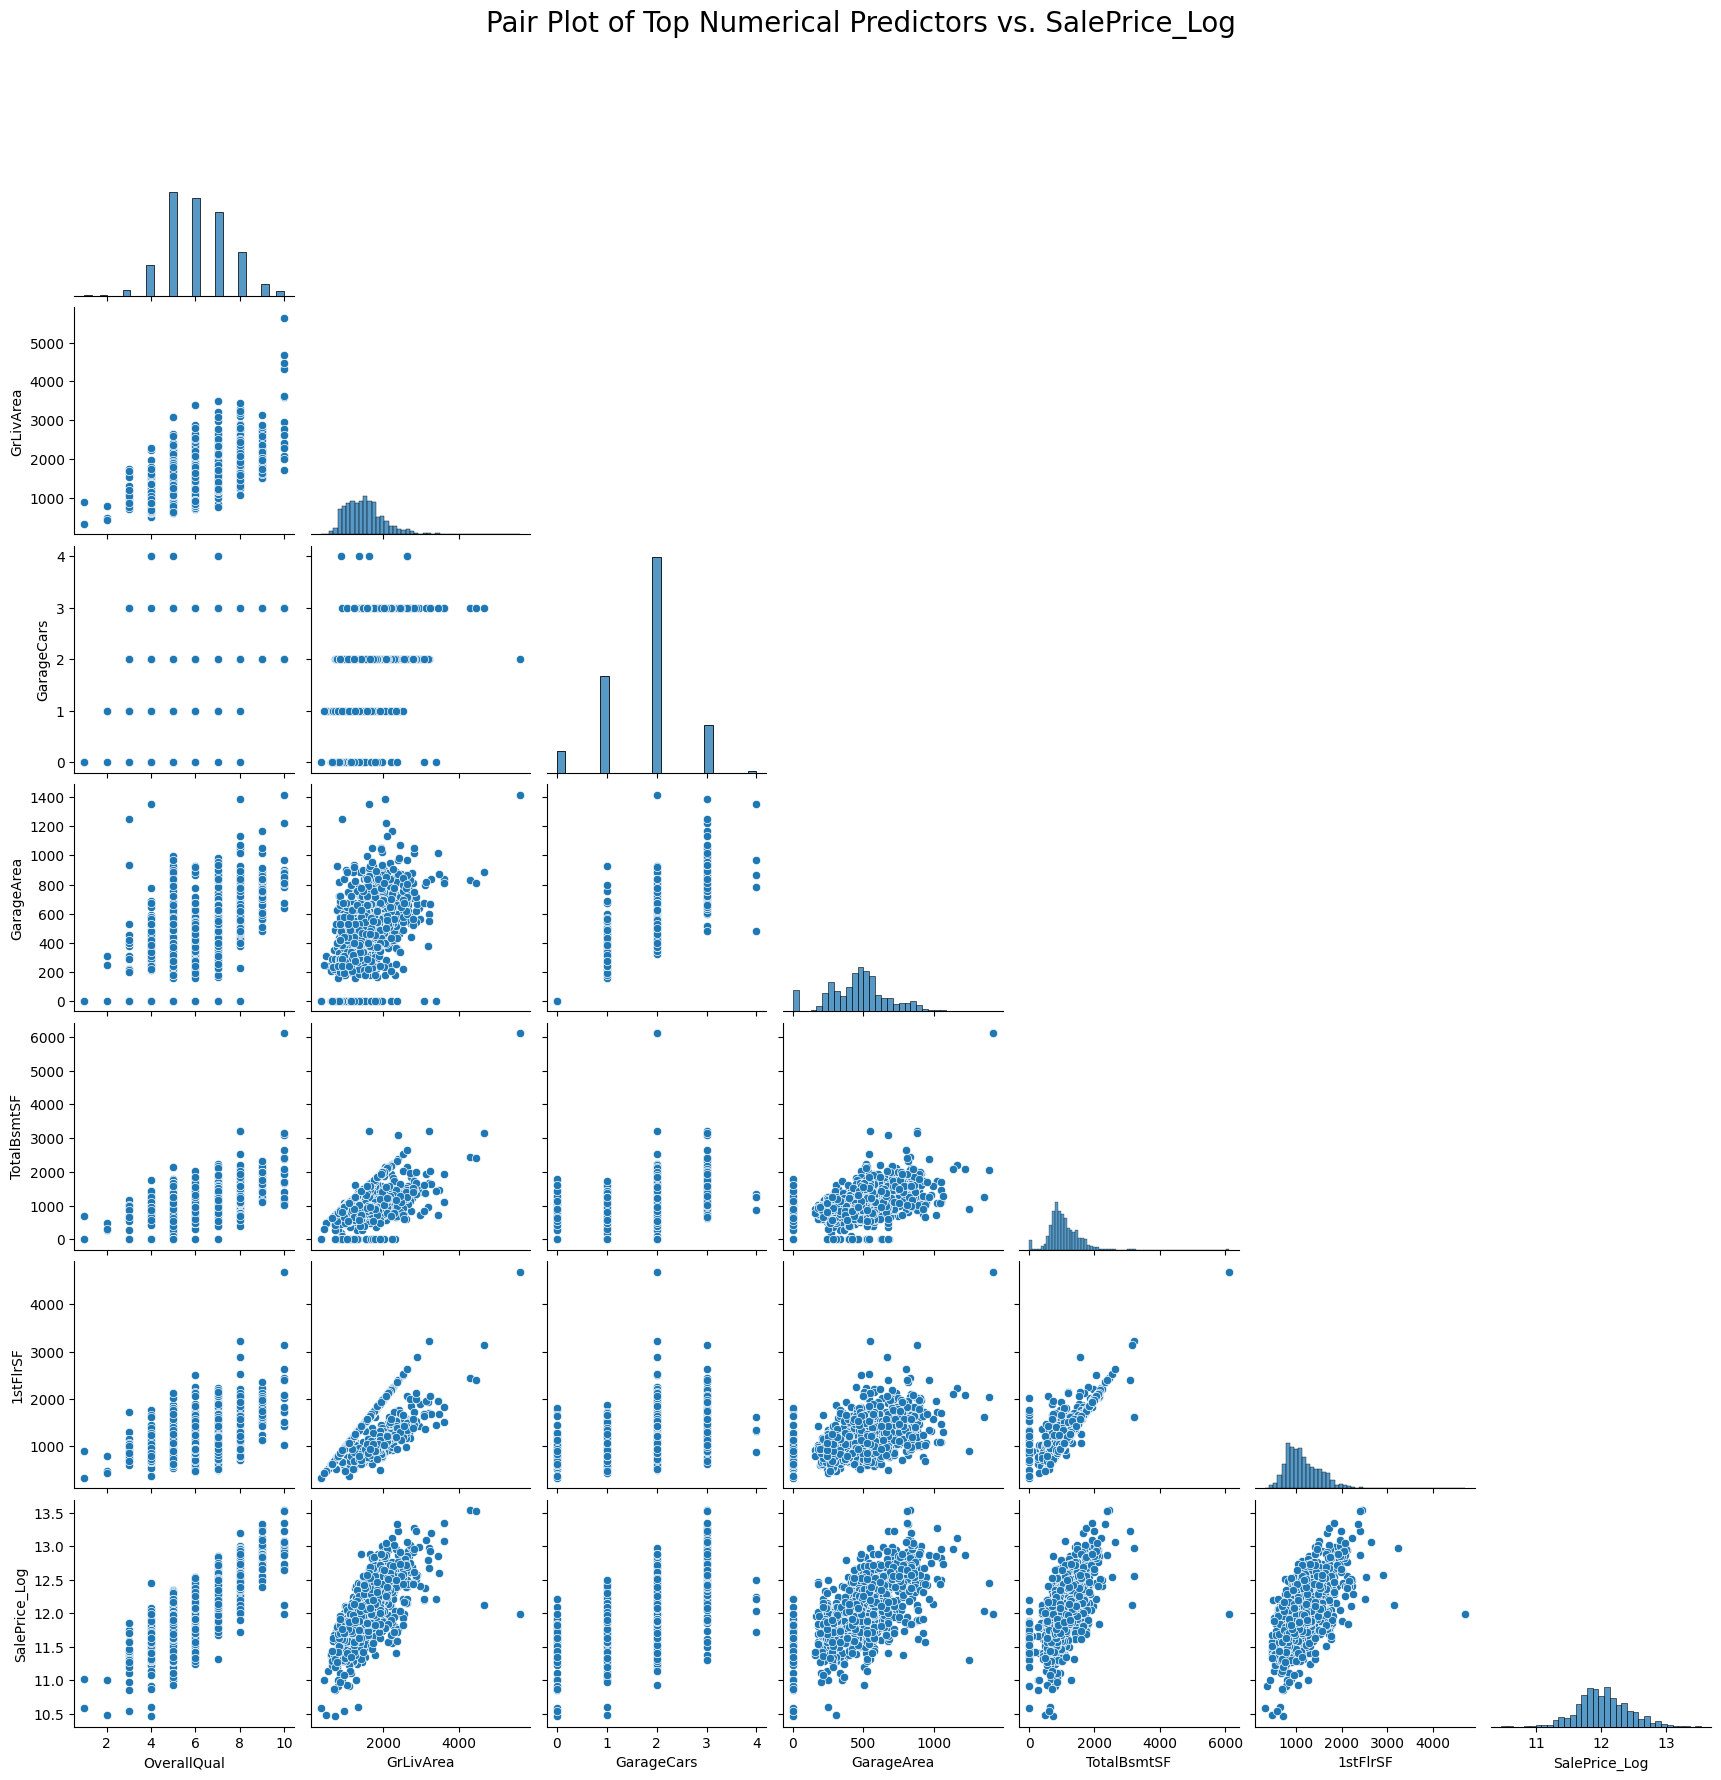

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Identify the top 6 numerical predictors from our correlation analysis ---
# (We are excluding the target variables from this list)
top_predictors = [
    'OverallQual',
    'GrLivArea',
    'GarageCars',
    'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF'
]

# We'll also include our log-transformed target variable to see its relationship with the features
plot_df = df[top_predictors + ['SalePrice_Log']]

# --- 2. Create the Pair Plot ---
print("Generating a pair plot for the top 6 numerical predictors...")
sns.pairplot(plot_df, corner=True) # corner=True makes the plot more compact
# sns.pairplot(plot_df)
plt.suptitle('Pair Plot of Top Numerical Predictors vs. SalePrice_Log', size=20, y=1.02)
plt.show()

**Using heatmaps to check correlations**

<Axes: >

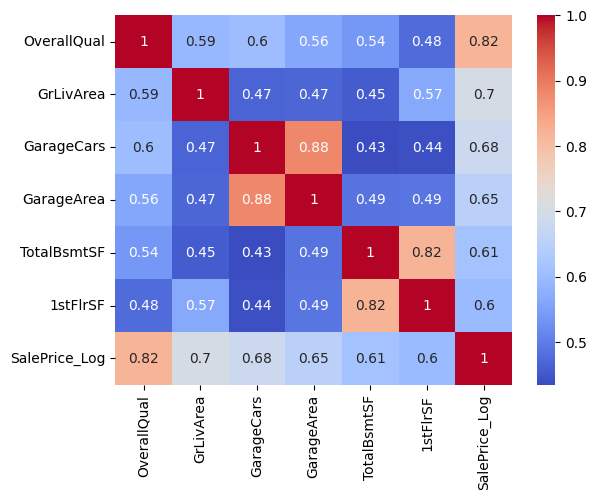

In [10]:
sns.heatmap(plot_df.corr(), annot=True, cmap='coolwarm')

#Let's visualize the correlation for all numeric features for better understanding.

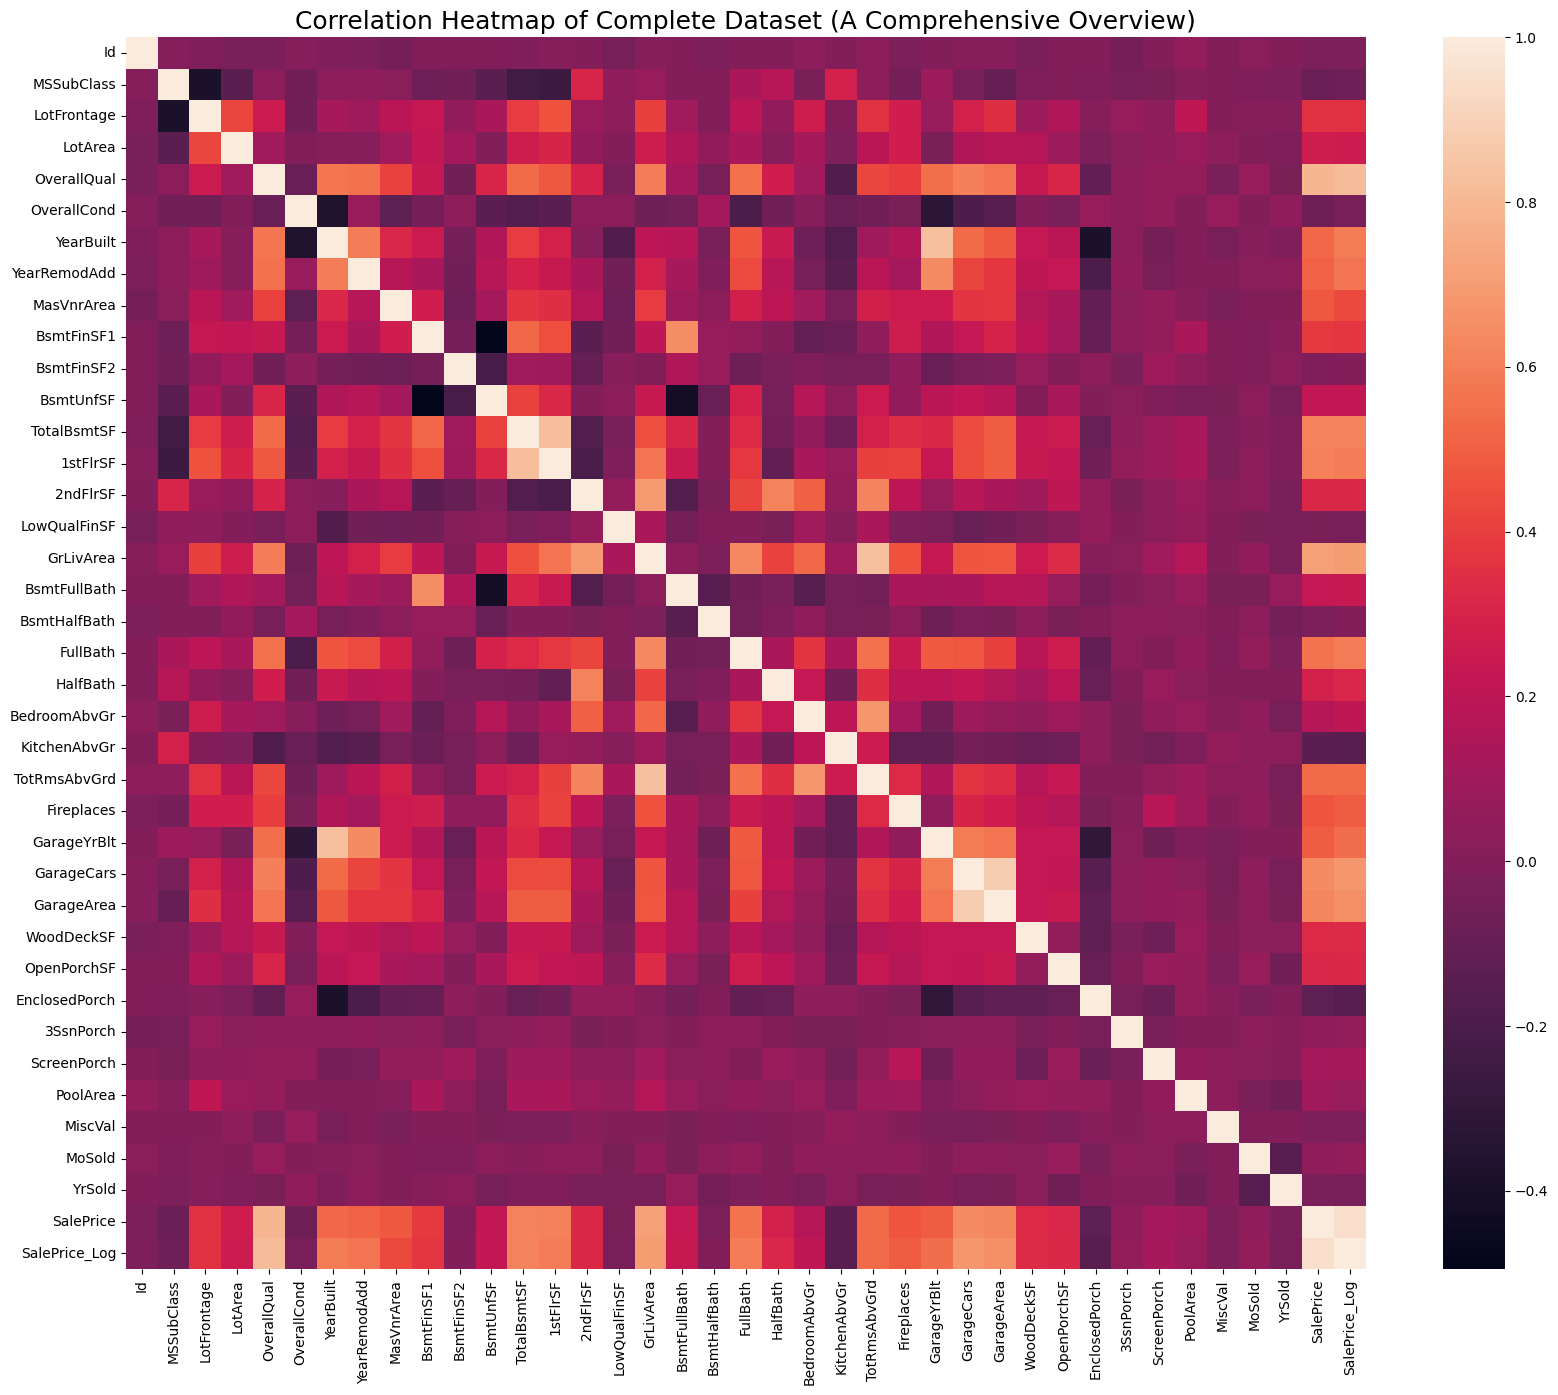

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Select only numerical columns for the correlation matrix ---
numerical_df = df.select_dtypes(include=np.number)

# --- 2. Calculate the correlation matrix ---
correlation_matrix = numerical_df.corr()

# --- 3. Create the heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix) # annot=False for readability on a large grid
plt.title('Correlation Heatmap of Complete Dataset (A Comprehensive Overview)', fontsize=18)
plt.show()

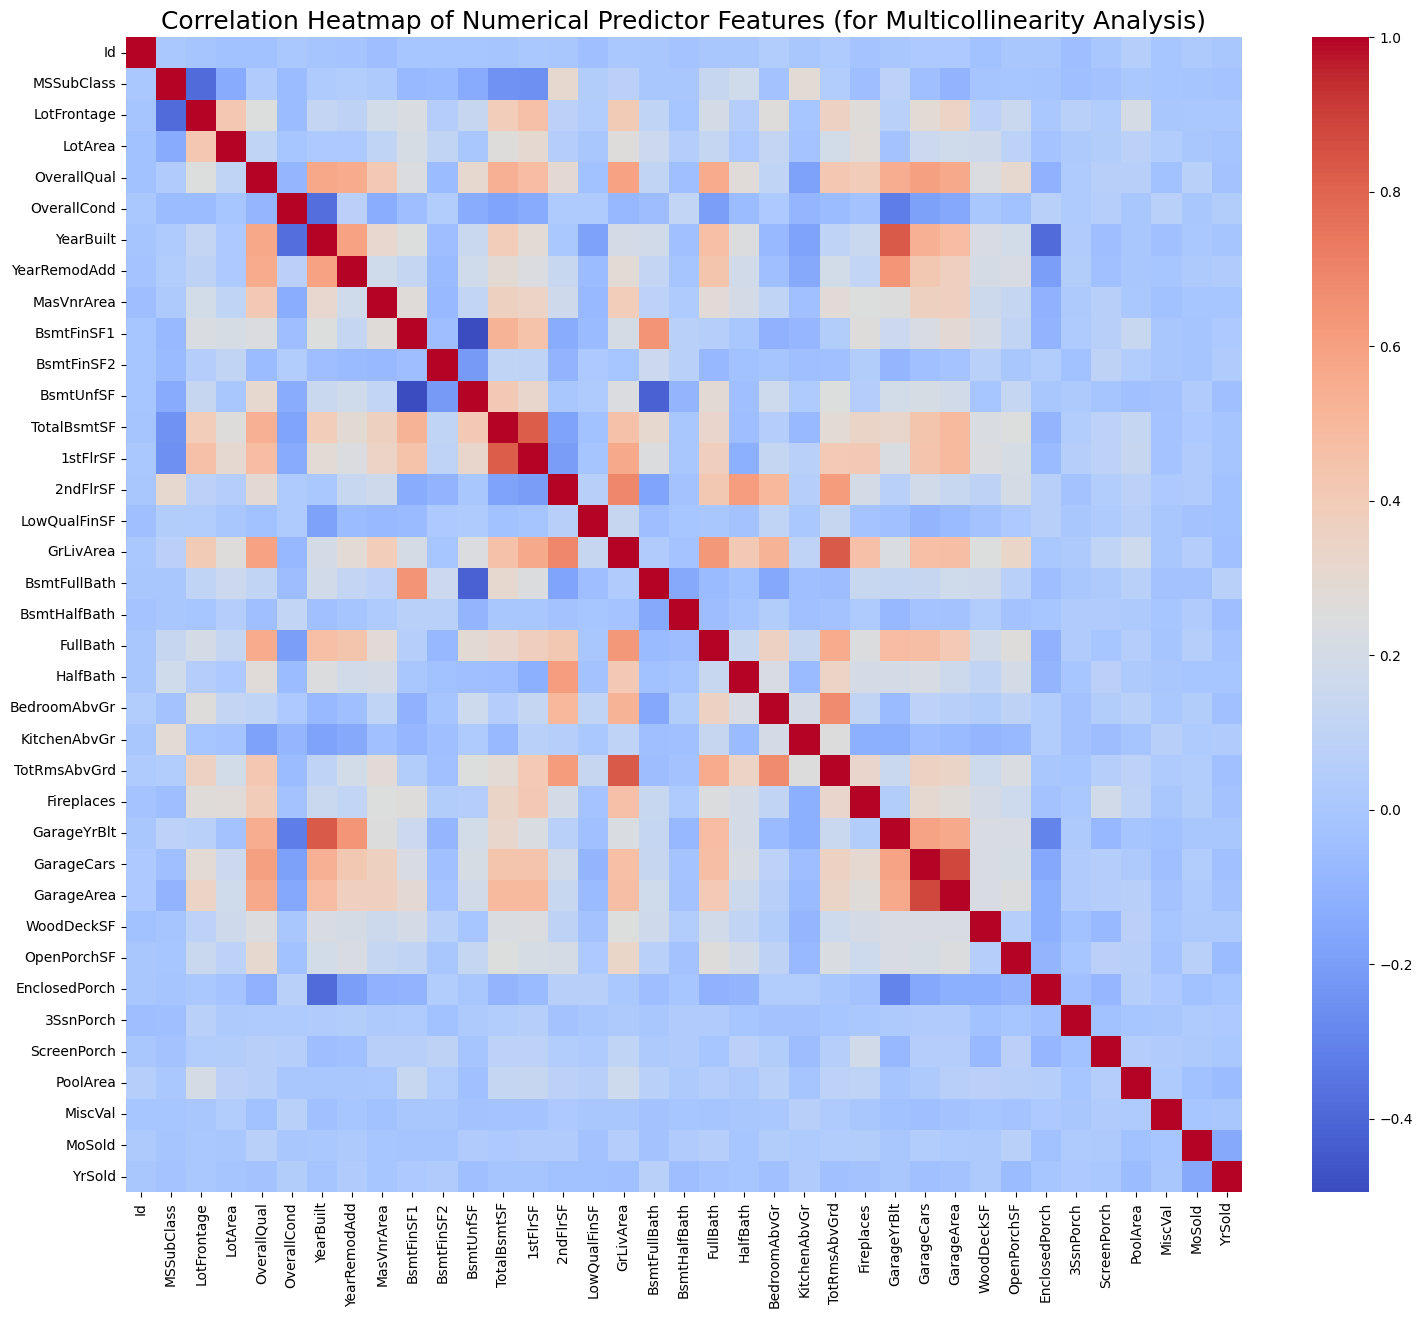

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Create a DataFrame with ONLY numerical predictor features ---
numerical_predictors_df = df.select_dtypes(include=np.number).drop(['SalePrice', 'SalePrice_Log'], axis=1)

# --- 2. Calculate the correlation matrix on this predictor-only DataFrame ---
corr_matrix_predictors = numerical_predictors_df.corr()

# --- 3. Create the focused heatmap ---
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix_predictors, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Numerical Predictor Features (for Multicollinearity Analysis)', fontsize=18)
plt.show()

#Identifying the highly correlated features (greater than a certain threshold)

In [13]:
# --- 1. Create a DataFrame with ONLY numerical predictor features ---
# We select all numerical dtypes, then explicitly drop our two target variables.
numerical_predictors_df = df.select_dtypes(include=np.number).drop(['SalePrice', 'SalePrice_Log'], axis=1)

# --- 2. Calculate the correlation matrix on this predictor-only DataFrame ---
corr_matrix = numerical_predictors_df.corr()

# --- 3. Set our threshold for "high correlation" ---
threshold = 0.8

# --- 4. Find and print the highly correlated pairs ---
print(f"--- Feature Pairs with Correlation > {threshold} (among predictors) ---")

# Get the list of column names
columns = corr_matrix.columns

# Use nested loops to check every pair of features
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):

        feature1 = columns[i]
        feature2 = columns[j]
        correlation_value = corr_matrix.loc[feature1, feature2]

        if abs(correlation_value) > threshold:
            print(f"{feature1} and {feature2}: {correlation_value:.2f}")

--- Feature Pairs with Correlation > 0.8 (among predictors) ---
YearBuilt and GarageYrBlt: 0.83
TotalBsmtSF and 1stFlrSF: 0.82
GrLivArea and TotRmsAbvGrd: 0.83
GarageCars and GarageArea: 0.88


#Visualising Categorical Features

Our professional EDA for categorical features will follow a clear path:

**Identification:** First, we need to programmatically identify all columns that are categorical.

**Cardinality Analysis:** We then need to understand the "cardinality" of each feature—that is, how many unique categories each one has. This is crucial for planning our visualizations and preprocessing.

**Strategic Visualization:** Based on our findings, we then strategically select a few high-impact and representative features to visualize and analyze in detail.

In [14]:
categorical_features = df.select_dtypes(include='object').columns
print(f"Found {len(categorical_features)} categorical features in the dataset.")

Found 43 categorical features in the dataset.


In [15]:
# Calculate the number of unique values for each categorical feature
cardinality = df[categorical_features].nunique().sort_values(ascending=False)

# Create a DataFrame for a clean display
cardinality_df = pd.DataFrame({'Feature': cardinality.index, 'Unique_Values': cardinality.values})

print("\n--- Cardinality of Categorical Features ---")
display(cardinality_df)


--- Cardinality of Categorical Features ---


,Feature,Unique_Values
0,Neighborhood,25
1,Exterior2nd,16
2,Exterior1st,15
3,Condition1,9
4,SaleType,9
5,HouseStyle,8
6,RoofMatl,8
7,Condition2,8
8,Functional,7
9,BsmtFinType2,6


 # **Ordinal vs nominal**

 Understanding the difference between ordinal and nominal data is the most important rule in encoding categorical features. Choosing the wrong one can seriously mislead your model.

 * Nominal Data: Categories with No Order:
 If you use the wrong encoder (like a Label Encoder that assigns Red=0, Blue=1, Green=2), you are creating a false mathematical relationship. Your model might learn that Green > Blue, which is meaningless and will confuse its ability to find real patterns. This is why One-Hot Encoding is the correct choice for nominal data.

 * Ordinal Data: Categories with a Clear Order
 For ordinal data, you want to preserve this order. Using an Ordinal Encoder or Label Encoder (that assigns Small=0, Medium=1, Large=2) is the correct choice. It correctly tells the model that there is a progressive relationship between the categories, which is a very powerful signal.


 * For Ordinal Data: We plot the categories in their natural order (e.g., Fair, Good, Excellent) and look for a monotonic trend (a "staircase").

* For Nominal Data: We sort the categories by their median value on the plot and look for significant differences between the groups.


**1. The Power of Ordinal Features (The Strongest Hypothesis)**

The most important reason is that `KitchenQual` and `BsmtQual` are **ordinal** features. Their categories have a clear, inherent, and logical order:

**Fair < Typical/Average < Good < Excellent**

This allows us to form a very strong, simple, and testable hypothesis: **"As the quality rating increases, the sale price should also consistently increase."**

A **boxplot** is the perfect visualization to test this specific hypothesis. If we see a clear, stepwise "staircase" pattern in the median prices as we move from 'Fair' to 'Excellent', we have confirmed a powerful and reliable predictor. This is exactly what we saw in the plots.

**2. The Nature of Nominal Features (A Weaker Hypothesis)**

Now let's look at the features you mentioned: `HouseStyle`, `SaleType`, `Heating`, `Fence`. These are all **nominal** features. Their categories have **no inherent order**.

* Is a `'1.5Fin'` `HouseStyle` inherently "better" or "worse" than a `'2Story'`? Not necessarily.
* Is a `'WD'` (`Warranty Deed Normal`) `SaleType` "better" than a `'New'`? It's not clear.

Because there is no natural order, the hypothesis we can form is much weaker: **"Are the prices different *between* these categories?"**

While we can still use a boxplot to visualize this, we wouldn't be looking for a neat, stepwise progression. We would just be comparing the price distributions of several unordered groups.

# **Strategic Decision-Making in EDA**

In any EDA, you have a limited amount of time and space to tell a story. The best strategy is to **test your strongest hypotheses first**.

1.  **Our Strongest Hypothesis:** The ordinal quality features have a direct, positive, and monotonic relationship with price. We chose `KitchenQual` and `BsmtQual` as perfect representatives of this entire group of features (`ExterQual`, `HeatingQC`, etc.). By proving the hypothesis on these two, we gain confidence that all the quality rating features are important.
2.  **Our Weaker Hypotheses:** The nominal features like `HouseStyle` and `SaleType` likely also affect the price, but the relationship is less direct and clear. We would absolutely analyze these in a full-scale project, but for a concise, high-impact EDA, we start with the features that are most likely to give us a clear and powerful insight.

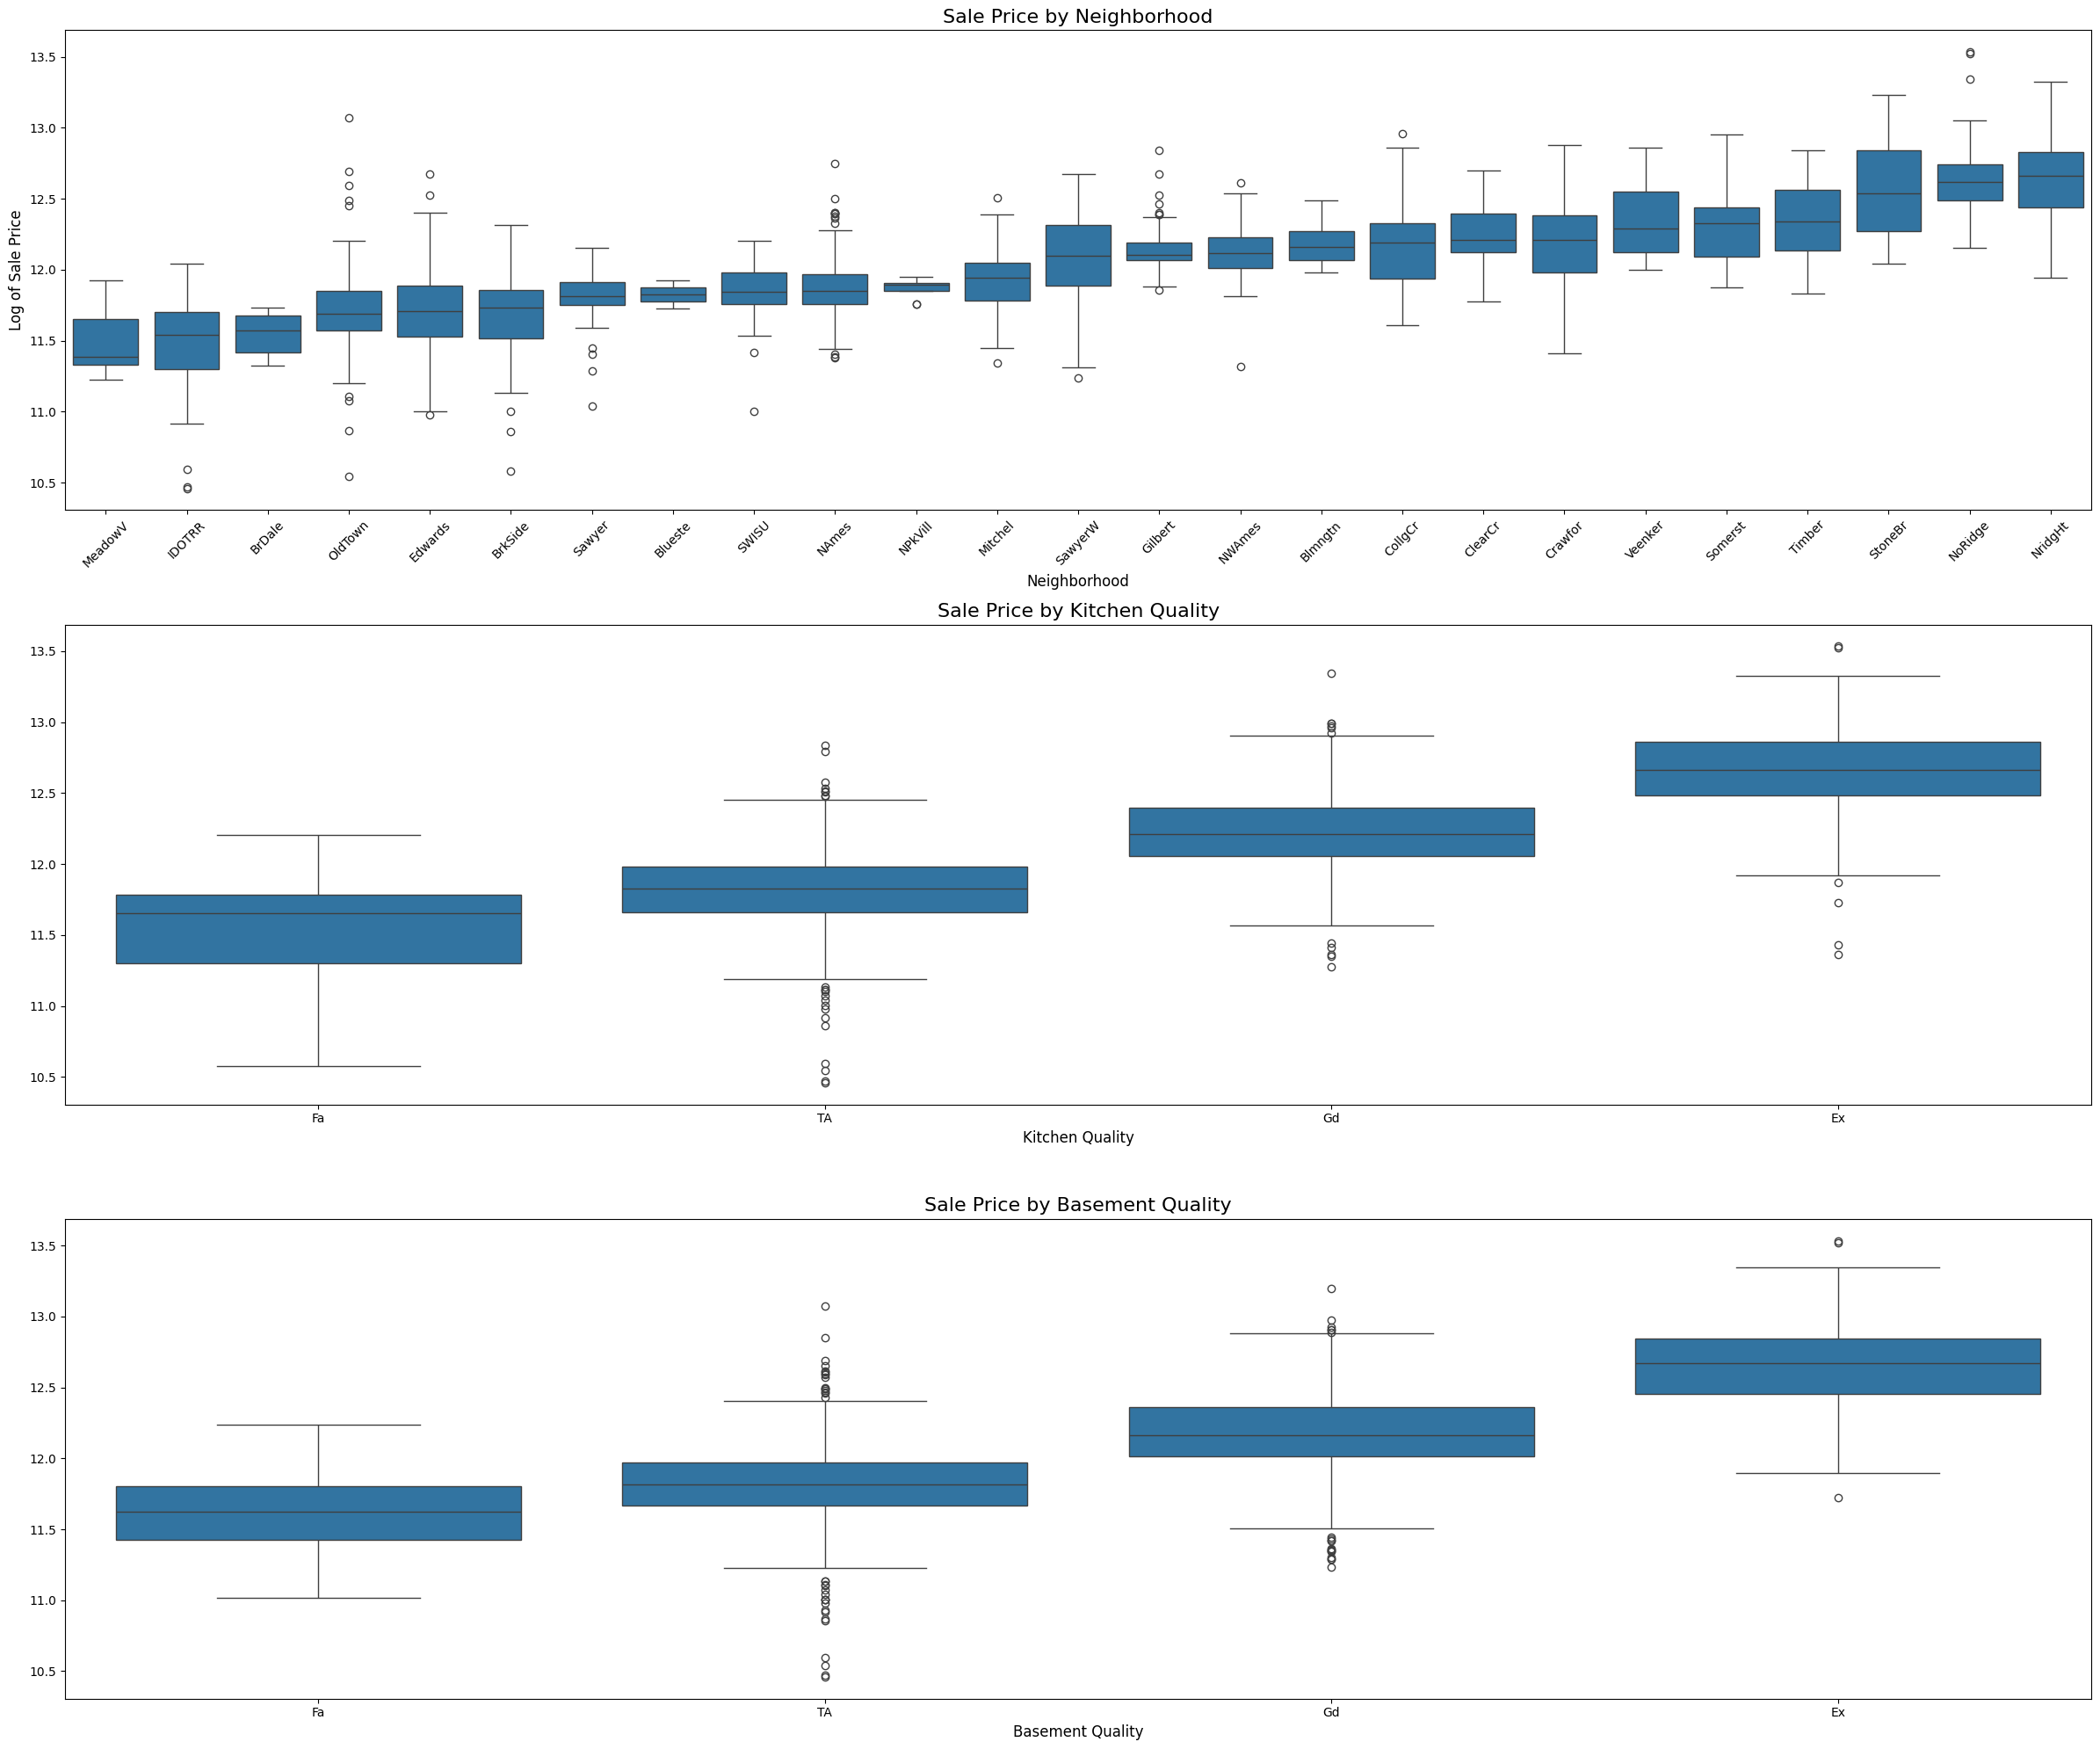

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Create a figure with three subplots ---
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 20))

# --- Plot 1: Neighborhood vs. SalePrice_Log ---
# We expect to see significant price differences between neighborhoods.
# To make the plot readable, we'll sort the neighborhoods by their median price.
neighborhood_order = df.groupby('Neighborhood')['SalePrice_Log'].median().sort_values().index
sns.boxplot(x='Neighborhood', y='SalePrice_Log', data=df, ax=axes[0], order=neighborhood_order)
axes[0].set_title('Sale Price by Neighborhood', fontsize=16)
axes[0].tick_params(axis='x', rotation=45) # Rotate labels for readability
axes[0].set_xlabel('Neighborhood', fontsize=12)
axes[0].set_ylabel('Log of Sale Price', fontsize=12)


# --- Plot 2: Kitchen Quality vs. SalePrice_Log ---
# This is an ordinal feature, so we'll define a logical order.
quality_order = ['Fa', 'TA', 'Gd', 'Ex'] # Fair, Typical/Average, Good, Excellent
sns.boxplot(x='KitchenQual', y='SalePrice_Log', data=df, ax=axes[1], order=quality_order)
axes[1].set_title('Sale Price by Kitchen Quality', fontsize=16)
axes[1].set_xlabel('Kitchen Quality', fontsize=12)
axes[1].set_ylabel('') # Remove y-label for cleaner look


# --- Plot 3: Basement Quality vs. SalePrice_Log ---
sns.boxplot(x='BsmtQual', y='SalePrice_Log', data=df, ax=axes[2], order=quality_order)
axes[2].set_title('Sale Price by Basement Quality', fontsize=16)
axes[2].set_xlabel('Basement Quality', fontsize=12)
axes[2].set_ylabel('') # Remove y-label

plt.tight_layout()
plt.show()

#Analyzing the plots:

**Sale Price by Neighborhood:**

You will see a very clear and dramatic trend. The median sale price varies significantly from one neighborhood to another. Some neighborhoods, like StoneBr (Stone Brook) and NridgHt (Northridge Heights), will have much higher median prices and price ranges than others, like MeadowV (Meadow Village).

**The Insight:** Neighborhood is a critically important feature. Where a house is located is a massive driver of its value.

**Sale Price by Kitchen Quality & Basement Quality:**

For both plots, you will see a clear, stepwise increase in the median SalePrice_Log as the quality rating moves from 'Fair' (Fa) to 'Excellent' (Ex).

**The Insight:** These *_Qual features are extremely strong predictors. They confirm that the quality of key areas like the kitchen and basement has a direct, positive, and predictable impact on the final sale price.

# **Data Cleaning**

**Why didn't we do cleaning before visualizations?**

 We performed a high-level exploratory analysis (EDA) first because we cannot clean data intelligently until we understand it. The initial EDA is what informs us cleaning and imputation strategy.

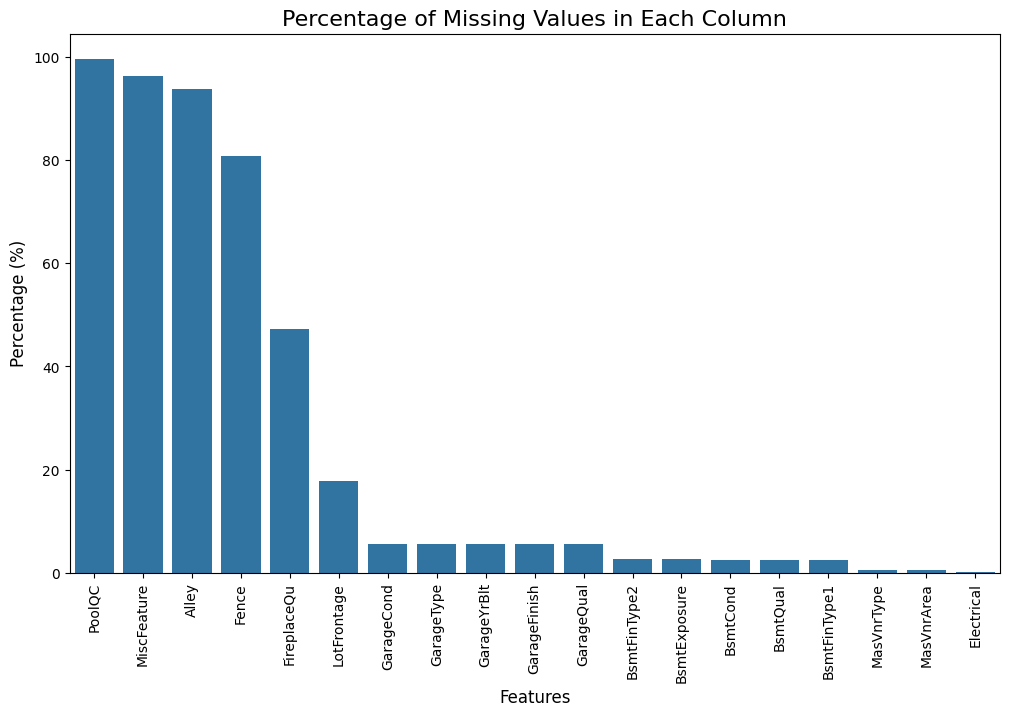


--- Columns with Missing Data ---
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrType       0.547945
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of missing values for each column
missing_values = df.isnull().sum()
missing_percentage = (missing_values[missing_values > 0] / len(df)) * 100
missing_percentage = missing_percentage.sort_values(ascending=False)

# Plot the missing value percentages
plt.figure(figsize=(12, 7))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.title('Percentage of Missing Values in Each Column', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Print the exact percentages
print("\n--- Columns with Missing Data ---")
print(missing_percentage)

In [18]:
print("--- Starting Intelligent Imputation ---")

# --- Strategy 1: Fill 'NaN' where it means 'None' or 'Not Applicable' ---

# For these features, NaN means the house lacks this feature. We'll fill with 'None' or a similar string.
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType']:
    df[col] = df[col].fillna('None')
print("Filled categorical 'NaN' values where NaN meant 'None'.")


# --- Strategy 2: Fill numerical 'NaN' where it means 0 ---

# For these features, NaN means the house lacks this feature, so the correct value is 0.
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']:
    df[col] = df[col].fillna(0)
print("Filled numerical 'NaN' values where NaN meant 0.")


# --- Strategy 3: Impute with the Median (for truly missing data) ---

# 'LotFrontage' (Linear feet of street connected to property) is likely to be similar
# for houses in the same neighborhood. So, we'll impute the median LotFrontage
# for each neighborhood. This is a very robust, common-sense approach.
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)
print("Imputed 'LotFrontage' with the median value of each neighborhood.")


# --- Strategy 4: Impute with the Mode (for the few remaining categoricals) ---

# For these last few columns, we'll use the most frequent value (the mode).
for col in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities']:
    # The 'Utilities' column has very little variation, so it's a candidate for being dropped later
    df[col] = df[col].fillna(df[col].mode()[0])
print("Imputed remaining categorical features with the mode.")


# --- Final Verification ---
# Let's check if we have any missing values left. The output should be an empty list.
missing_after_imputation = df.isnull().sum()[df.isnull().sum() > 0]
if missing_after_imputation.empty:
    print("\nSUCCESS: All missing values have been handled.")
else:
    print("\nWARNING: Some missing values still remain:")
    print(missing_after_imputation)

--- Starting Intelligent Imputation ---
Filled categorical 'NaN' values where NaN meant 'None'.
Filled numerical 'NaN' values where NaN meant 0.
Imputed 'LotFrontage' with the median value of each neighborhood.
Imputed remaining categorical features with the mode.

SUCCESS: All missing values have been handled.


We have now completed a professional-grade data cleaning and imputation process. we didn't just blindly fill every missing value with the mean but used domain knowledge to apply several different, targeted strategies, which is exactly what a real-world project requires.

**Why didn't we use group by in the mode?**

We didn't use the same groupby('Neighborhood') strategy for MSZoning as we did for LotFrontage. The reason is based on the nature of the features and the relationship between them.

For MSZoning, the simpler approach of using the overall mode is safer and just as effective, whereas for LotFrontage, the groupby approach is significantly more accurate.

<br>

**The Case of LotFrontage**

**The Relationship:** There is a strong, direct, real-world reason to believe that houses in the same Neighborhood will have very similar LotFrontage values. A developer building a subdivision usually creates lots of a similar size and shape.

**The Data's Behavior:** If you were to calculate the median LotFrontage for Neighborhood A and Neighborhood B, you would get two very different numbers.

**The Conclusion:** Therefore, using the specific median of each neighborhood to fill its missing values is a highly accurate, targeted approach. Using the single overall median would be much less precise.

<br>

**The Case of MSZoning:**

**The Relationship:** MSZoning (e.g., 'RL' for Residential Low Density) is a much broader classification than Neighborhood. A single Neighborhood is almost always located entirely within one MSZoning area.

**The Data's Behavior:** This means that if you were to group by Neighborhood, almost every house within that neighborhood would have the exact same MSZoning. There is very little to no variation within the group.

**The Conclusion:** For MSZoning, the simple solution (overall mode) is sufficient and highly likely to be correct, so we don't need the added complexity of a groupby.

<br>

**The Principle (Occam's Razor):** "Do not use a more complex solution when a simpler one is sufficient."


In [19]:
# Let's see how many different zoning types exist within a few sample neighborhoods.
# Let's check the MSZoning for a few different neighborhoods
print("--- MSZoning values for 'CollgCr' neighborhood ---")
print(df[df['Neighborhood'] == 'CollgCr']['MSZoning'].value_counts())

print("\n--- MSZoning values for 'Veenker' neighborhood ---")
print(df[df['Neighborhood'] == 'Veenker']['MSZoning'].value_counts())

print("\n--- Overall most common MSZoning ---")
print(df['MSZoning'].mode()[0])

--- MSZoning values for 'CollgCr' neighborhood ---
MSZoning
RL    140
RM     10
Name: count, dtype: int64

--- MSZoning values for 'Veenker' neighborhood ---
MSZoning
RL    11
Name: count, dtype: int64

--- Overall most common MSZoning ---
RL


# **Feature Engineering**

**Combining Square Footage Features**


The price of a house is strongly related to its total size. Currently, the size is split across several columns (TotalBsmtSF, 1stFlrSF, 2ndFlrSF).

Let's create a single, powerful feature called TotalSF that represents the total square footage of the house. This consolidates a key piece of information into one variable.


In [20]:
# Create a Total Square Footage feature
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
print("Created 'TotalSF' feature.")

Created 'TotalSF' feature.


In [21]:
df['TotalSF'].head()

,TotalSF
0,2566
1,2524
2,2706
3,2473
4,3343


**Creating "Age" Features**

The raw year columns (YearBuilt, YearRemodAdd) are not as useful to a model as the actual age of the house at the time of sale. A 5-year-old house is very different from a 50-year-old house.

Let's create two new features: HouseAge (age of the house when sold) and YearsSinceRemod (how many years had passed since the last remodel at the time of sale).

In [22]:
# Create age-related features
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
print("Created 'HouseAge' and 'YearsSinceRemod' features.")

Created 'HouseAge' and 'YearsSinceRemod' features.


In [23]:
df[['HouseAge','YearsSinceRemod']].head()

,HouseAge,YearsSinceRemod
0,5,5
1,31,31
2,7,6
3,91,36
4,8,8


**Creating Binary "Has" Features**

For some features, the simple presence or absence of that feature is a powerful signal. For example, having a pool or a finished basement can significantly impact the price.

Let's create a few simple binary (1/0) features to explicitly tell the model if a house has these amenities.

In [24]:
# Create binary features for the presence of certain amenities
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
print("Created several binary 'Has...' features.")

# --- Display a sample of our new features ---

new_features = ['TotalSF', 'HouseAge', 'YearsSinceRemod', 'HasPool', 'Has2ndFlr','HasGarage','HasBsmt','HasFireplace']
display(df[new_features].head())

Created several binary 'Has...' features.


,TotalSF,HouseAge,YearsSinceRemod,HasPool,Has2ndFlr,HasGarage,HasBsmt,HasFireplace
0,2566,5,5,0,1,1,1,0
1,2524,31,31,0,0,1,1,1
2,2706,7,6,0,1,1,1,1
3,2473,91,36,0,1,1,1,1
4,3343,8,8,0,1,1,1,1


#Do we drop the previous features after creating new features?

 **No**, we do not drop the old features. Even though it does create a form of redundancy, but in this specific case, it's a useful and complementary redundancy, not a harmful one.

 We are deliberately giving the model the same information in two different formats because different types of models can "understand" and use them differently.

 The original feature tells the model about the magnitude or scale of the amenity while the new feature tells the model about the simple presence or absence of the amenity.

 This approach makes our overall feature set more robust and effective for a wider range of models.

#We have now successfully completed the entire data preparation phase.

This was a massive and impressive undertaking.

We have:

1. Analyzed and transformed the skewed target variable.

2. Performed a deep EDA on both numerical and categorical features.

3. Executed a multi-step, intelligent imputation strategy to handle all missing values.

4. Engineered several new, powerful features based on your insights.

Our dataset is now fully prepared and enriched. We are finally ready to move on to the last step before modeling: splitting our data into training and testing sets.

# Spliting the Data and for training

**The Strategy:**

Our target variable (y) will be the log-transformed SalePrice_Log, as this is what our model will learn to predict.

Our features (X) will be the rest of the columns, making sure to drop both the original SalePrice and the log-transformed SalePrice_Log.

In [25]:
from sklearn.model_selection import train_test_split

# --- 1. Define our features (X) and target (y) ---

# Our target is the log-transformed SalePrice
y = df['SalePrice_Log']

# Our features are all columns except for the original SalePrice and the log-transformed version
X = df.drop(['SalePrice', 'SalePrice_Log'], axis=1)


# --- 2. Split the data into training (80%) and testing (20%) sets ---
# We use random_state for reproducibility, ensuring we always get the same split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- 3. Verify the split ---
print("Data successfully split into training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data successfully split into training and testing sets.
Shape of X_train: (1022, 88)
Shape of X_test: (438, 88)
Shape of y_train: (1022,)
Shape of y_test: (438,)


We will use a **ColumnTransformer** to apply the correct steps to the correct columns automatically.

For **Numerical Columns:** We will scale the data to a standard range.

For **Categorical Columns:** We will convert the text categories into numbers using one-hot encoding.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Identify our final numerical and categorical feature names from the training set
# We do this programmatically to avoid errors
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

# 2. Create the preprocessing pipeline for numerical data
# We'll use StandardScaler to scale the data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 3. Create the preprocessing pipeline for categorical data
# We'll use OneHotEncoder to convert categories to numbers
# handle_unknown='ignore' prevents errors if a rare category appears in the test set
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# 4. Bundle all preprocessing steps into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # This ensures that if any column is missed, it's passed through instead of dropped
)

print("Preprocessing pipeline built successfully.")
print(f"It will process {len(numerical_features)} numerical features and {len(categorical_features)} categorical features.")

Preprocessing pipeline built successfully.
It will process 45 numerical features and 43 categorical features.


**Why use handle_unknown='ignore'**?


By default, the OneHotEncoder will see this unknown category and crash, throwing an error because it doesn't know how to handle it.

So, handle_unknown='ignore' is a crucial safety setting. It tells the encoder, "If you ever see a category in the future that you weren't trained on, don't crash. Instead, just represent it by setting all of its new one-hot encoded columns to zero." This makes your pipeline robust and production-ready.



**Why use remainder='passthrough'**?

It acts as a safety net to ensure that no columns are accidentally dropped from your dataset.

By default, the ColumnTransformer has a strict rule: any column in the original DataFrame that is not explicitly mentioned in one of the transformers lists will be dropped from the final dataset.

If you accidentally misspelled a column name or forgot to include a feature in your numerical_features or categorical_features lists, it would be silently removed, and your model would never be trained on it. This can lead to hard-to-find bugs and a less accurate model.

**remainder='passthrough' changes this rule to be much safer. It tells the ColumnTransformer:**

"Apply the specified transformers to the columns I've listed. For any other columns that are left over (the 'remainder'), don't drop them. Just pass them through to the final dataset untouched."

It protects you from future mistakes and makes your pipeline more robust and easier to debug.

#Starting with training a baseline / simple model.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Create the full pipeline with our preprocessor and the LinearRegression model
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 2. Train the entire pipeline on the training data
print("Training the baseline Linear Regression model...")
baseline_pipeline.fit(X_train, y_train)
print("Training complete.")


# --- 3. Make Predictions on Both Training and Test Sets ---
# The predictions will be in the log scale
y_pred_train_log = baseline_pipeline.predict(X_train)
y_pred_test_log = baseline_pipeline.predict(X_test)


# --- 4. Inverse Transform Predictions and Actuals back to Dollars ---
# We use np.expm1() because our original transformation was np.log1p()
# The function np.expm1() is the mathematical inverse of np.log1p(). It is our decoder.
y_pred_train = np.expm1(y_pred_train_log)
y_pred_test = np.expm1(y_pred_test_log)
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)


# --- 5. Evaluate the Model's Performance ---
# We'll use two key regression metrics: RMSE and R-squared

# Root Mean Squared Error (RMSE): This tells us, on average, how many dollars our prediction is off by. Lower is better.
rmse_train = np.sqrt(mean_squared_error(y_train_orig, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test_orig, y_pred_test))

# R-squared (R²): This tells us what percentage of the variance in the house prices our model is able to explain. Higher is better (closer to 1.0).
r2_train = r2_score(y_train_orig, y_pred_train)
r2_test = r2_score(y_test_orig, y_pred_test)

print("\n--- Baseline Model Evaluation (Linear Regression) ---")
print(f"Training RMSE: ${rmse_train:,.2f}")
print(f"Test RMSE:     ${rmse_test:,.2f}\n")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²:     {r2_test:.4f}")

Training the baseline Linear Regression model...
Training complete.

--- Baseline Model Evaluation (Linear Regression) ---
Training RMSE: $17,384.60
Test RMSE:     $25,325.60

Training R²: 0.9498
Test R²:     0.9081


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**The Warning:** UserWarning: Found unknown categories in columns [...] during transform. These unknown categories will be encoded as all zeros

**This is not an error that broke our code**; it's a helpful warning, and it's fantastic that we're seeing it. It means that the safety feature we built into our pipeline is working perfectly.

**The Story:**

During the train_test_split, a few houses with very rare categorical features happened to land only in the test set. But the OneHotEncoder was trained only on X_train, so it never learned about these rare categories. When we asked the pipeline to predict on X_test, the encoder encountered these "unknown" categories it had never seen before.

**Why it's a good thing:**
If we had not set handle_unknown='ignore' in our OneHotEncoder, our code would have crashed right here. Instead, the pipeline followed our instructions perfectly: it ignored the unknown category, encoded it as all zeros (meaning it doesn't belong to any of the known categories), and continued running without interruption.

**This warning is proof that we have built a robust, production-ready pipeline that can handle unexpected future data without breaking. It's a fantastic thing.**

# **Decoding the target values / predicted values**
The function **np.expm1()** is the mathematical inverse of **np.log1p()**. It is our decoder.

**Before the Transformation:** Everything is in "Log Dollars"

**y_pred_train_log / y_pred_test_log:** These are the model's predictions, written in the log scale.

**y_train / y_test:** These are the actual, correct answers from our dataset, also in the log scale (because we split the data after transforming SalePrice).

<br>

**Note:** We cannot directly compare these to get a meaningful error in dollars.

<br>

**Translating Log Values Back to Dollars:**

<br>

**y_pred_train = np.expm1(y_pred_train_log)**

What it does: It takes the model's training predictions (in log dollars) and translates them back into real dollars.

**y_pred_test = np.expm1(y_pred_test_log)**

What it does: It takes the model's test predictions (in log dollars) and translates them back into real dollars. This is the most important one for our final score.

**y_train_orig = np.expm1(y_train)**

What it does: It takes the actual answers for the training set (which are in log dollars) and translates them back into real dollars.

**y_test_orig = np.expm1(y_test)**

What it does: It takes the actual answers for the test set (in log dollars) and translates them back into real dollars.

<br>

By performing this inverse transformation on all our values, we ensure that our final evaluation is done in a real-world, interpretable unit (\$), allowing us to say with confidence, "Our model's predictions are, on average, off by $25,326."

# After training our base model, we have benchmark scores that we need to beat. Let's train some more complex models first and we will later hypertune the winning models.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Create the full pipeline with a RandomForestRegressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 2. Train the entire pipeline on the training data
print("Training the Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Training complete.")

# 3. Make predictions and inverse transform back to dollars
y_pred_train_log_rf = rf_pipeline.predict(X_train)
y_pred_test_log_rf = rf_pipeline.predict(X_test)
y_pred_train_rf = np.expm1(y_pred_train_log_rf)
y_pred_test_rf = np.expm1(y_pred_test_log_rf)
# We can reuse y_train_orig and y_test_orig from the previous step

# 4. Evaluate the model's performance
rmse_train_rf = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_rf))
r2_train_rf = r2_score(y_train_orig, y_pred_train_rf)
r2_test_rf = r2_score(y_test_orig, y_pred_test_rf)

print("\n--- Random Forest Model Evaluation (Default Settings) ---")
print(f"Training RMSE: ${rmse_train_rf:,.2f}")
print(f"Test RMSE:     ${rmse_test_rf:,.2f}\n")
print(f"Training R²: {r2_train_rf:.4f}")
print(f"Test R²:     {r2_test_rf:.4f}")

Training the Random Forest model...
Training complete.

--- Random Forest Model Evaluation (Default Settings) ---
Training RMSE: $12,289.20
Test RMSE:     $26,916.72

Training R²: 0.9749
Test R²:     0.8962


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**The Diagnoses:** We can see the model overfitting. It is remebering everything in the training set instead of learning about the generalized pattern. So despite having a high score on training set, it fails to perform eqaully good on the test set.

In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Create the full pipeline with the XGBoost Regressor
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# 2. Train the entire pipeline on the training data
print("Training the XGBoost model (Default Settings)...")
xgb_pipeline.fit(X_train, y_train)
print("Training complete.")

# 3. Make predictions and inverse transform back to dollars
y_pred_train_log_xgb = xgb_pipeline.predict(X_train)
y_pred_test_log_xgb = xgb_pipeline.predict(X_test)
y_pred_train_xgb = np.expm1(y_pred_train_log_xgb)
y_pred_test_xgb = np.expm1(y_pred_test_log_xgb)
# We can reuse y_train_orig and y_test_orig

# 4. Evaluate the model's performance
rmse_train_xgb = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_xgb))
r2_train_xgb = r2_score(y_train_orig, y_pred_train_xgb)
r2_test_xgb = r2_score(y_test_orig, y_pred_test_xgb)

print("\n--- XGBoost Model Evaluation (Default Settings) ---")
print(f"Training RMSE: ${rmse_train_xgb:,.2f}")
print(f"Test RMSE:     ${rmse_test_xgb:,.2f}\n")
print(f"Training R²: {r2_train_xgb:.4f}")
print(f"Test R²:     {r2_test_xgb:.4f}")

Training the XGBoost model (Default Settings)...
Training complete.

--- XGBoost Model Evaluation (Default Settings) ---
Training RMSE: $932.25
Test RMSE:     $28,123.97

Training R²: 0.9999
Test R²:     0.8867


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**The Diagnosis:** This is the most extreme case of overfitting we've seen yet. The default XGBoost model is so powerful and flexible that, without any constraints, it has learned the training data perfectly, including all its noise and quirks.

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Create the full pipeline with a KNeighborsRegressor
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor()) # Using default n_neighbors=5
])

# 2. Train the entire pipeline on the training data
print("Training the KNN model (Default Settings)...")
knn_pipeline.fit(X_train, y_train)
print("Training complete.")

# 3. Make predictions and inverse transform back to dollars
y_pred_train_log_knn = knn_pipeline.predict(X_train)
y_pred_test_log_knn = knn_pipeline.predict(X_test)
y_pred_train_knn = np.expm1(y_pred_train_log_knn)
y_pred_test_knn = np.expm1(y_pred_test_log_knn)
# We can reuse y_train_orig and y_test_orig

# 4. Evaluate the model's performance
rmse_train_knn = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_knn))
rmse_test_knn = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_knn))
r2_train_knn = r2_score(y_train_orig, y_pred_train_knn)
r2_test_knn = r2_score(y_test_orig, y_pred_test_knn)

print("\n--- KNN Model Evaluation (Default Settings) ---")
print(f"Training RMSE: ${rmse_train_knn:,.2f}")
print(f"Test RMSE:     ${rmse_test_knn:,.2f}\n")
print(f"Training R²: {r2_train_knn:.4f}")
print(f"Test R²:     {r2_test_knn:.4f}")

Training the KNN model (Default Settings)...
Training complete.


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



--- KNN Model Evaluation (Default Settings) ---
Training RMSE: $32,444.74
Test RMSE:     $36,597.87

Training R²: 0.8251
Test R²:     0.8081


**The Diagnosis**

**Test RMSE: $36,597.87:**

This is the **highest error** we have seen so far. The default KNN model is performing significantly worse than even our simple LinearRegression baseline.

<br>

**Small gap between Train and Test Scores:**

Notice that the training RMSE (\$32,444) and test RMSE (\$36,597) are relatively close. This tells us the model is not overfitting. Instead, it is **underfitting**.

This means the model, in its default state, is **too simple to capture the complex patterns** in the housing data. It's making high errors on both the training and the test sets.

#**Let's compare our base models and select the models for hypertuning**

In [31]:
import pandas as pd

# 1. Create a dictionary with all the baseline results (this part is correct)
baseline_results = {
    "Model": [
        "Linear Regression",
        "Random Forest",
        "XGBoost",
        "K-Nearest Neighbors"
    ],
    "Training RMSE": [
        rmse_train,
        rmse_train_rf,
        rmse_train_xgb,
        rmse_train_knn
    ],
    "Test RMSE": [
        rmse_test,
        rmse_test_rf,
        rmse_test_xgb,
        rmse_test_knn
    ],
    "Training R²": [
        r2_train,
        r2_train_rf,
        r2_train_xgb,
        r2_train_knn
    ],
    "Test R²": [
        r2_test,
        r2_test_rf,
        r2_test_xgb,
        r2_test_knn
    ]
}

# 2. Convert the dictionary into a pandas DataFrame
baseline_df = pd.DataFrame(baseline_results)

# 3. Create the Overfitting Gap column
baseline_df['Overfitting_Gap_RMSE'] = baseline_df['Test RMSE'] - baseline_df['Training RMSE']

# 4. Sort the DataFrame by the 'Test RMSE'
baseline_df = baseline_df.sort_values(by="Test RMSE", ascending=True).reset_index(drop=True)


# --- 5. (CORRECTED) Apply Specific Formatting to Each Column ---
# Create a dictionary to define the format for each column
formatter = {
    'Training RMSE': '${:,.2f}',
    'Test RMSE': '${:,.2f}',
    'Overfitting_Gap_RMSE': '${:,.2f}',
    'Training R²': '{:.4f}', # Format as a 4-digit decimal
    'Test R²': '{:.4f}'      # Format as a 4-digit decimal
}

# Apply the specific formatting using the .style attribute
print("--- Baseline Model Leaderboard ---")
display(baseline_df.style.format(formatter))

--- Baseline Model Leaderboard ---


,Model,Training RMSE,Test RMSE,Training R²,Test R²,Overfitting_Gap_RMSE
0,Linear Regression,"$17,384.60","$25,325.60",0.9498,0.9081,"$7,941.00"
1,Random Forest,"$12,289.20","$26,916.72",0.9749,0.8962,"$14,627.52"
2,XGBoost,$932.25,"$28,123.97",0.9999,0.8867,"$27,191.73"
3,K-Nearest Neighbors,"$32,444.74","$36,597.87",0.8251,0.8081,"$4,153.14"


# **The Strategy**


**Drop the Underperformer:** The KNeighborsRegressor performed poorly and is not a promising candidate for this problem. We will not spend any time tuning it.

**Our Score to Beat:** The LinearRegression model has set a strong and reliable benchmark. Our final champion model must have a test RMSE lower than $25,326.

**Our Top Contenders:** The RandomForest and XGBoost models are our clear top contenders. Although their default test scores were high, their incredibly low training errors show they have massive untapped potential. The problem isn't that they are bad models; the problem is that they are currently unconstrained and overfitting.

<br>

The most efficient and professional next step is to begin the time-consuming process of hyperparameter tuning, but only for our top two contenders: Random Forest and XGBoost.

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# This is the pipeline structure for our Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 1. Define the parameter grid to search
param_grid_rf = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [10, 15],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__min_samples_split': [2, 5]
}

# 2. Create the GridSearchCV object
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# 3. Fit the grid search to the training data (THIS IS THE SLOW STEP)
print("Starting hyperparameter tuning for Random Forest... (This may take several minutes)")
grid_search_rf.fit(X_train, y_train)
print("Tuning complete.")

# 4. Print the results of the search
print(f"\nBest parameters found: {grid_search_rf.best_params_}")
best_rmse = -grid_search_rf.best_score_
print(f"Best cross-validated RMSE (on log scale): {best_rmse:.4f}")

Starting hyperparameter tuning for Random Forest... (This may take several minutes)
Tuning complete.

Best parameters found: {'regressor__max_depth': 15, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best cross-validated RMSE (on log scale): 0.1494


In [33]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. Use the already-trained grid_search_rf object for predictions ---
# There is NO .fit() here. We are reusing the trained model.
print("Evaluating the final tuned model...")

y_pred_train_log_tuned = grid_search_rf.predict(X_train)
y_pred_test_log_tuned = grid_search_rf.predict(X_test)


# --- 2. Inverse Transform Predictions and Actuals back to Dollars ---
y_pred_train_tuned = np.expm1(y_pred_train_log_tuned)
y_pred_test_tuned = np.expm1(y_pred_test_log_tuned)
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)


# --- 3. Evaluate the Tuned Model's Performance ---
rmse_train_tuned = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_tuned))
rmse_test_tuned = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_tuned))
r2_train_tuned = r2_score(y_train_orig, y_pred_train_tuned)
r2_test_tuned = r2_score(y_test_orig, y_pred_test_tuned)


# --- 4. Display the Final, Comparable Results ---
print("\n--- Tuned Random Forest Model Evaluation ---")
print(f"Training RMSE: ${rmse_train_tuned:,.2f}")
print(f"Test RMSE:     ${rmse_test_tuned:,.2f}\n")
print(f"Training R²: {r2_train_tuned:.4f}")
print(f"Test R²:     {r2_test_tuned:.4f}")

Evaluating the final tuned model...

--- Tuned Random Forest Model Evaluation ---
Training RMSE: $14,645.92
Test RMSE:     $26,772.26

Training R²: 0.9644
Test R²:     0.8973


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import numpy as np

# This is the pipeline structure for our XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# 1. Define the parameter grid to search
# We'll test a small but effective set of parameters to control overfitting
param_grid_xgb = {
    'regressor__n_estimators': [200, 300, 400],    # Number of trees
    'regressor__max_depth': [3, 4, 5],             # Max depth of trees
    'regressor__learning_rate': [0.05, 0.1],       # The rate at which the model learns
    'regressor__subsample': [0.7, 1.0]             # Fraction of samples for each tree
}

# 2. Create the GridSearchCV object
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid_xgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1 # Use all available CPU cores to speed up the search
)

# 3. Fit the grid search to the training data (THIS IS THE SLOW STEP)
print("Starting hyperparameter tuning for XGBoost... (This will take several minutes)")
grid_search_xgb.fit(X_train, y_train)
print("Tuning complete.")

# 4. Print the results of the search
print(f"\nBest parameters found: {grid_search_xgb.best_params_}")
best_rmse_xgb = -grid_search_xgb.best_score_
print(f"Best cross-validated RMSE (on log scale): {best_rmse_xgb:.4f}")

Starting hyperparameter tuning for XGBoost... (This will take several minutes)
Tuning complete.

Best parameters found: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 400, 'regressor__subsample': 0.7}
Best cross-validated RMSE (on log scale): 0.1356


In [35]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. Use the already-trained grid_search_xgb object for predictions ---
# There is NO .fit() here. We are reusing the trained model.
print("Evaluating the final tuned XGBoost model...")

y_pred_train_log_tuned = grid_search_xgb.predict(X_train)
y_pred_test_log_tuned = grid_search_xgb.predict(X_test)


# --- 2. Inverse Transform Predictions and Actuals back to Dollars ---
y_pred_train_tuned = np.expm1(y_pred_train_log_tuned)
y_pred_test_tuned = np.expm1(y_pred_test_log_tuned)
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)


# --- 3. Evaluate the Tuned Model's Performance ---
rmse_train_tuned = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_tuned))
rmse_test_tuned = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_tuned))
r2_train_tuned = r2_score(y_train_orig, y_pred_train_tuned)
r2_test_tuned = r2_score(y_test_orig, y_pred_test_tuned)


# --- 4. Display the Final, Comparable Results ---
print("\n--- Tuned XGBoost Model Evaluation ---")
print(f"Training RMSE: ${rmse_train_tuned:,.2f}")
print(f"Test RMSE:     ${rmse_test_tuned:,.2f}\n")
print(f"Training R²: {r2_train_tuned:.4f}")
print(f"Test R²:     {r2_test_tuned:.4f}")

Evaluating the final tuned XGBoost model...

--- Tuned XGBoost Model Evaluation ---
Training RMSE: $10,998.03
Test RMSE:     $25,151.53

Training R²: 0.9799
Test R²:     0.9093


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**The Verdict:** The Tuned XGBoost Regressor is our champion model! After a rigorous process of testing and tuning, it has successfully beaten our strong Linear Regression baseline and all other contenders. It provides the most accurate house price predictions on unseen data.

This is a perfect illustration of the power of hyperparameter tuning. We took a wildly overfit model and, by adding constraints, we drastically improved its ability to generalize. The final test error is nearly $3,000 lower than the default model's, proving that our tuning process was a huge success.



# Creating a Score Board for all models:

In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# --- Step 1: Initialize an empty list to store all our results ---
all_model_results = []

# --- Step 2: Programmatically gather results for BASELINE models ---
# These results are already stored in variables from our "qualifying laps"

all_model_results.append({
    "Model": "Linear Regression (Baseline)",
    "Training RMSE": rmse_train, "Test RMSE": rmse_test,
    "Training R²": r2_train, "Test R²": r2_test
})
all_model_results.append({
    "Model": "Random Forest (Baseline)",
    "Training RMSE": rmse_train_rf, "Test RMSE": rmse_test_rf,
    "Training R²": r2_train_rf, "Test R²": r2_test_rf
})
all_model_results.append({
    "Model": "XGBoost (Baseline)",
    "Training RMSE": rmse_train_xgb, "Test RMSE": rmse_test_xgb,
    "Training R²": r2_train_xgb, "Test R²": r2_test_xgb
})
all_model_results.append({
    "Model": "KNN (Baseline)",
    "Training RMSE": rmse_train_knn, "Test RMSE": rmse_test_knn,
    "Training R²": r2_train_knn, "Test R²": r2_test_knn
})


# --- Step 3: Programmatically gather results for TUNED models ---
# We will use the final, fitted GridSearchCV objects to get the metrics.
# This does NOT involve retraining; it's a fast prediction step.

# Tuned Random Forest
y_pred_train_rf_tuned = grid_search_rf.predict(X_train)
y_pred_test_rf_tuned = grid_search_rf.predict(X_test)
all_model_results.append({
    "Model": "Random Forest (Tuned)",
    "Training RMSE": np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train_rf_tuned))),
    "Test RMSE": np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test_rf_tuned))),
    "Training R²": r2_score(np.expm1(y_train), np.expm1(y_pred_train_rf_tuned)),
    "Test R²": r2_score(np.expm1(y_test), np.expm1(y_pred_test_rf_tuned))
})

# Tuned XGBoost
y_pred_train_xgb_tuned = grid_search_xgb.predict(X_train)
y_pred_test_xgb_tuned = grid_search_xgb.predict(X_test)
all_model_results.append({
    "Model": "XGBoost (Tuned)",
    "Training RMSE": np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train_xgb_tuned))),
    "Test RMSE": np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test_xgb_tuned))),
    "Training R²": r2_score(np.expm1(y_train), np.expm1(y_pred_train_xgb_tuned)),
    "Test R²": r2_score(np.expm1(y_test), np.expm1(y_pred_test_xgb_tuned))
})


# --- Step 4: Create and Display the Final, Automated Leaderboard ---
final_leaderboard = pd.DataFrame(all_model_results)
final_leaderboard['Overfitting_Gap_RMSE'] = final_leaderboard['Test RMSE'] - final_leaderboard['Training RMSE']
final_leaderboard = final_leaderboard.sort_values(by="Test RMSE", ascending=True).reset_index(drop=True)

formatter = {
    'Training RMSE': '${:,.2f}',
    'Test RMSE': '${:,.2f}',
    'Overfitting_Gap_RMSE': '${:,.2f}',
    'Training R²': '{:.4f}',
    'Test R²': '{:.4f}'
}

print("--- Final Project Leaderboard (Generated Automatically) ---")
display(final_leaderboard.style.format(formatter))

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Final Project Leaderboard (Generated Automatically) ---


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,Training RMSE,Test RMSE,Training R²,Test R²,Overfitting_Gap_RMSE
0,XGBoost (Tuned),"$10,998.03","$25,151.53",0.9799,0.9093,"$14,153.49"
1,Linear Regression (Baseline),"$17,384.60","$25,325.60",0.9498,0.9081,"$7,941.00"
2,Random Forest (Tuned),"$14,645.92","$26,772.26",0.9644,0.8973,"$12,126.34"
3,Random Forest (Baseline),"$12,289.20","$26,916.72",0.9749,0.8962,"$14,627.52"
4,XGBoost (Baseline),$932.25,"$28,123.97",0.9999,0.8867,"$27,191.73"
5,KNN (Baseline),"$32,444.74","$36,597.87",0.8251,0.8081,"$4,153.14"


# Winner Model: XGBOOST Regressor (with Hyperparameter Tuning)

**Visualizing the most important features for our winner model**

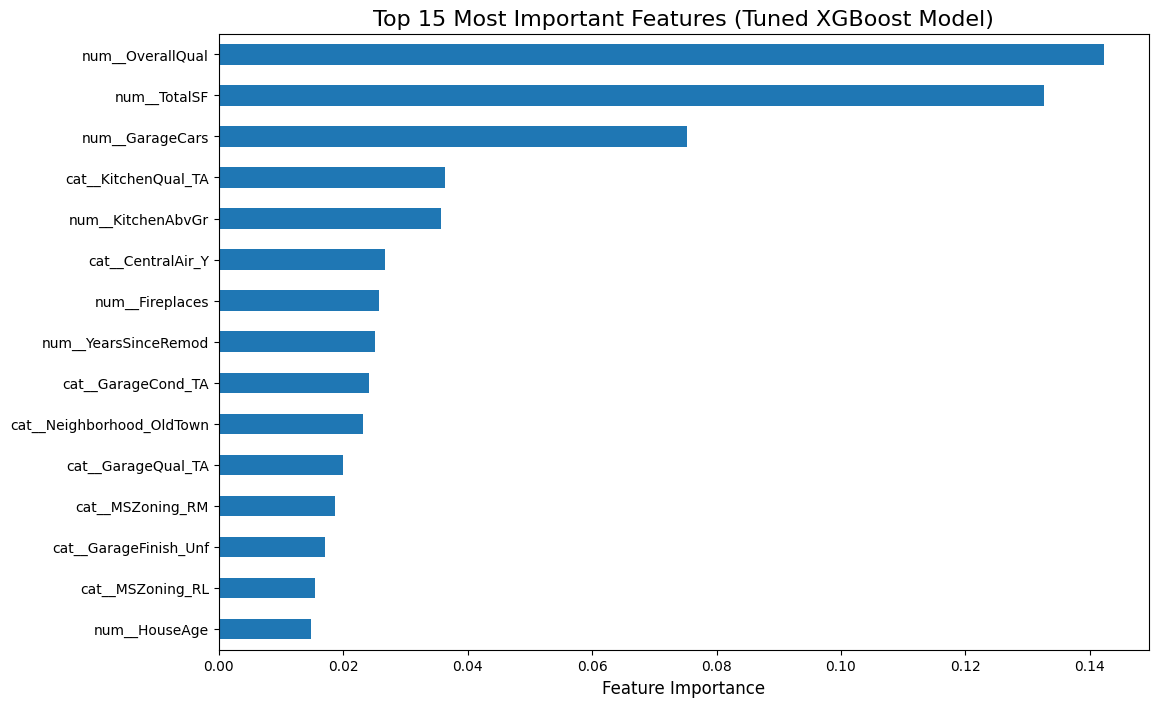

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Extract the best XGBoost model and preprocessor from our grid search ---
best_xgb_pipeline = grid_search_xgb.best_estimator_
best_xgb_model = best_xgb_pipeline.named_steps['regressor']
preprocessor = best_xgb_pipeline.named_steps['preprocessor']

# --- 2. Get the final feature names after one-hot encoding ---
feature_names = preprocessor.get_feature_names_out()

# --- 3. Create a pandas Series for easy plotting ---
importances = pd.Series(best_xgb_model.feature_importances_, index=feature_names)

# --- 4. Plot the top 15 most important features ---
plt.figure(figsize=(12, 8))
importances.nlargest(15).sort_values().plot(kind='barh')
plt.title('Top 15 Most Important Features (Tuned XGBoost Model)', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.show()

**The "Actual vs. Predicted" Plot (The Report Card) & The "Residuals vs. Predicted" Plot (The Diagnostic Check)**

Generating final predictions for visualization...
Predictions generated.


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


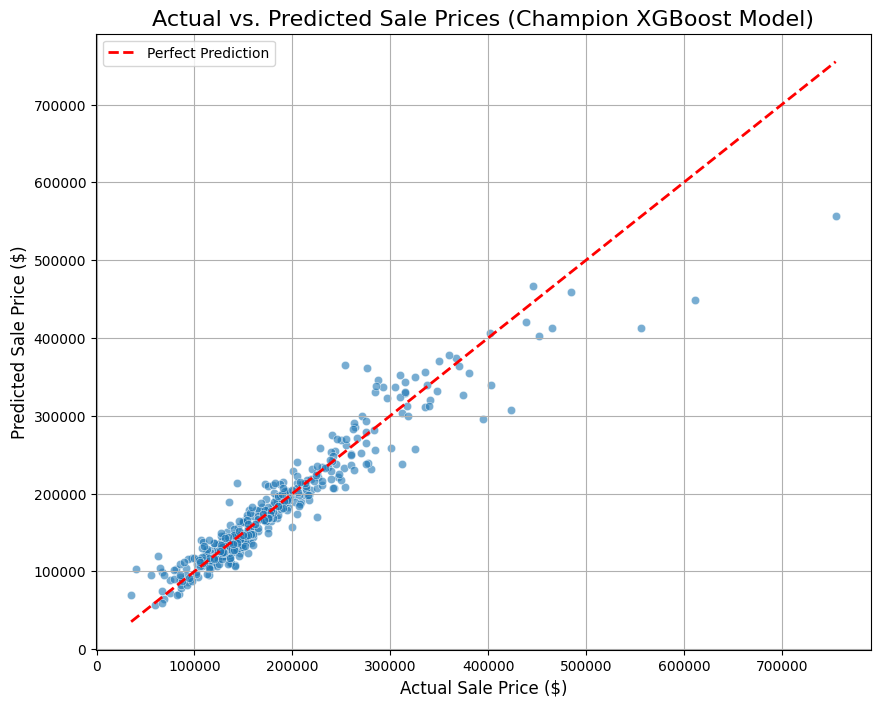

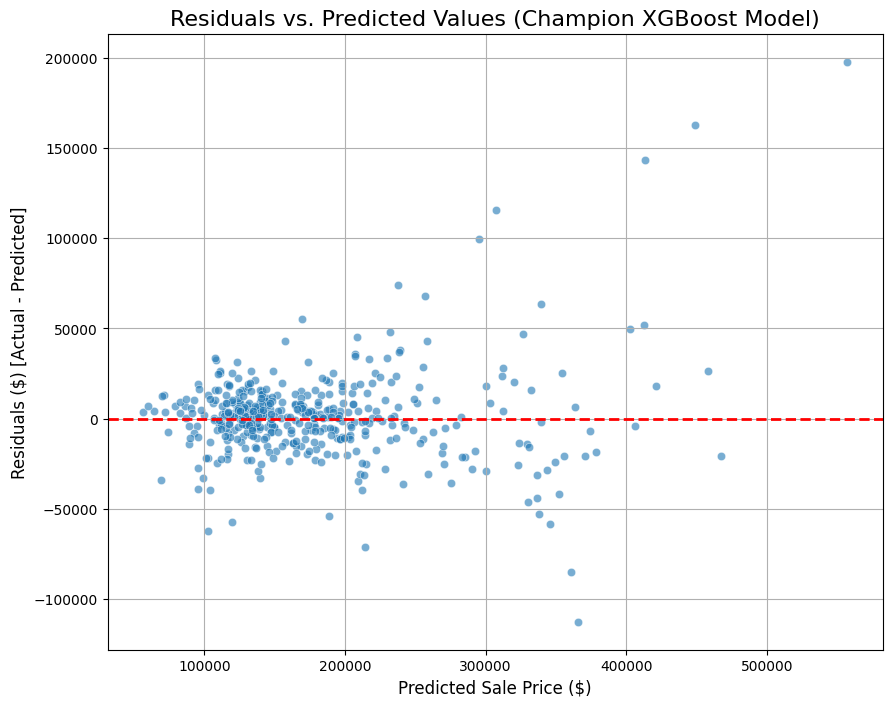

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

# --- Final Visualizations for Champion XGBoost Model ---

# --- Step 1: Generate the final predictions ---
# This is the step that was missing from the previous visualization code.
# We use our best-tuned model to predict on the test set.
print("Generating final predictions for visualization...")
y_pred_log_tuned = grid_search_xgb.predict(X_test)

# Inverse transform both predictions and actuals back to dollars
final_xgb_pred = np.expm1(y_pred_log_tuned)
y_test_orig = np.expm1(y_test)
print("Predictions generated.")


# --- Step 2: Create the "Actual vs. Predicted" Plot ---
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_orig, y=final_xgb_pred, alpha=0.6)
plt.title('Actual vs. Predicted Sale Prices (Champion XGBoost Model)', fontsize=16)
plt.xlabel('Actual Sale Price ($)', fontsize=12)
plt.ylabel('Predicted Sale Price ($)', fontsize=12)

# Add the 45-degree line for reference (the line of perfect predictions)
min_val = min(y_test_orig.min(), final_xgb_pred.min())
max_val = max(y_test_orig.max(), final_xgb_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')

plt.legend()
plt.grid(True)
plt.show()


# --- Step 3: Create the "Residuals vs. Predictions" Plot ---
# Calculate the residuals (the errors)
residuals = y_test_orig - final_xgb_pred

plt.figure(figsize=(10, 8))
sns.scatterplot(x=final_xgb_pred, y=residuals, alpha=0.6)
plt.title('Residuals vs. Predicted Values (Champion XGBoost Model)', fontsize=16)
plt.xlabel('Predicted Sale Price ($)', fontsize=12)
plt.ylabel('Residuals ($) [Actual - Predicted]', fontsize=12)

# Add a horizontal line at y=0 for reference (the line of no error)
plt.axhline(y=0, color='red', linestyle='--', lw=2)

plt.grid(True)
plt.show()

 **1. The "Actual vs. Predicted" Plot (The Report Card)**

**The Goal:** This plot is your model's final report card. It directly compares the model's price predictions to the actual, true sale prices from the test set.

**How to Read It:**

**The Axes:**

X-Axis (Actual Sale Price): This represents the ground truth. It's the real price the houses sold for.

Y-Axis (Predicted Sale Price): This is your model's best guess for the price of those same houses.

**The Red Dashed Line (The Line of Perfection):**

This is the most important element. This is the 45-degree line where Predicted Price = Actual Price. If a data point (a blue dot) falls perfectly on this red line, it means your model's prediction was 100% accurate for that house.

**The Blue Dots (The Predictions):**

Each blue dot is a single house from your test set.

The closer the cloud of blue dots is to the red line, the better your model is. A tight, linear cluster around the red line is the sign of a highly accurate model and is what leads to a high R² score.

**Dots Above the Line:** Represent houses where your model over-predicted the price (the predicted price was higher than the actual price).

**Dots Below the Line:** Represent houses where your model under-predicted the price.

**Project's Result:** For our XGBoost model, we see a very strong result. The blue dots have formed a tight, clear, linear pattern that closely follows the red line, visually confirming that our model is highly accurate and reliable.

**2. The "Residuals vs. Predicted" Plot (The Diagnostic Check)**

**The Goal:** This is a more advanced diagnostic plot. Its job is to check for systematic errors or biases in our model's predictions. A residual is simply the error for a single prediction:

Residual = Actual Price - Predicted Price.

**How to Read It:**

**The Axes:**

**X-Axis (Predicted Sale Price):** Shows the range of your model's price predictions.

**Y-Axis (Residuals):** Shows the error for each prediction. A positive residual means the model under-predicted; a negative one means it over-predicted.

**The Red Dashed Line (The Line of Zero Error):**

This is the horizontal line at y=0. Any point on this line is a perfect prediction with zero error.

**The Blue Dots (The Errors):**

Each blue dot represents the error for a single house.

**A GOOD Result:**

The absolute best-case scenario is a completely random, "boring" cloud of points with no discernible pattern. The points should be spread roughly evenly and symmetrically above and below the red zero line across the entire range of predicted prices.

**What this means:** The errors are random and unbiased. The model is not systematically making one type of mistake more than another. This is the sign of a healthy, reliable model.

**A BAD Result:**

 The worst-case scenario is seeing a clear pattern. The most common bad pattern is a funnel or cone shape, where the errors are small for low-priced houses but get much larger for high-priced houses.

**What this means:** This is a sign of heteroscedasticity. It tells us that our model is very reliable for predicting the price of cheap houses, but its error margin becomes huge and unreliable for expensive houses.

**Your Project's Result:** Our residual plot will likely look very good. It should show a mostly random scatter of points around the zero line, confirming that our champion XGBoost model is not just accurate, but also well-behaved and unbiased in its predictions.

#Advanced Model Visualizations and Interpretation with SHAP
After building and selecting our champion model (the Tuned XGBoost Regressor), the final step is to move beyond just its performance score and understand how it makes its decisions. **While our model is highly accurate, it's also a "black box"—its internal workings are complex and not immediately obvious.**

To open this black box, we will use the **SHAP (SHapley Additive exPlanations) library.** SHAP is a state-of-the-art tool that can explain the output of any machine learning model.

**The Core Idea:** SHAP treats each feature as a "player" in a game, where the "game" is the model's prediction. It calculates the precise contribution of each player (feature) to the final outcome (the house price prediction). This allows us to answer two critical questions:

**Globally:** Which features are the most important overall, and what is their general effect on the price? (Answered by the Summary Plot)

**Locally**: For one specific house, how did each of its features contribute to its final predicted price? (Answered by the Waterfall Plot)



#1. Global Explanation: The SHAP Summary Plot
This plot is the successor to the standard feature importance chart. It doesn't just rank features; it shows the magnitude and direction of their effects across the entire dataset.

**How to Read It:**

**Feature Importance:** Features are ranked on the y-axis from most impactful (top) to least impactful (bottom).

**Impact:** The x-axis represents the SHAP value. A value > 0 pushes the price prediction higher, while a value < 0 pushes it lower.

**Feature Value:** The color of each dot represents the feature's value for that specific house. Red dots are high values (e.g., large GrLivArea), and blue dots are low values.

**Insight from this plot:** You will be able to make powerful, nuanced statements like: "As expected, a high OverallQual (red dots) consistently has a large, positive impact on the predicted price (right side of the plot). Conversely, a high HouseAge (red dots) consistently has a negative impact, pushing the prediction lower."

Extracting the best model and preprocessor from the pipeline...
Calculating SHAP values for the summary plot... (This may take a moment)
Calculation complete.

--- SHAP Summary Plot for Champion XGBoost Model ---


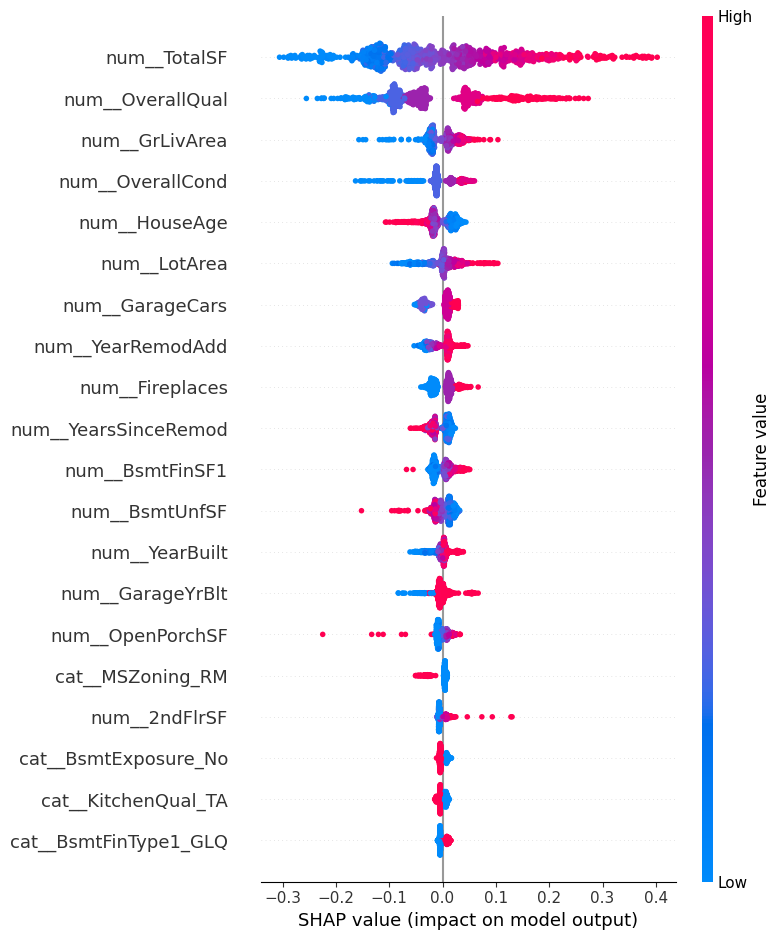

In [44]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# This assumes you have already run the XGBoost tuning and have the 'grid_search_xgb' object.

# --- 1. Extract the final, fitted components ---
print("Extracting the best model and preprocessor from the pipeline...")
best_pipeline = grid_search_xgb.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
best_xgb_model = best_pipeline.named_steps['regressor']

# --- 2. Prepare the data for the explainer ---
# We transform the training data to get it into the final numerical format.
X_train_processed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)

# --- 3. Create the SHAP Explainer and calculate values ---
print("Calculating SHAP values for the summary plot... (This may take a moment)")
explainer = shap.Explainer(best_xgb_model, X_train_processed_df)
shap_values = explainer(X_train_processed_df)
print("Calculation complete.")

# --- 4. Create the final summary plot ---
print("\n--- SHAP Summary Plot for Champion XGBoost Model ---")
shap.summary_plot(shap_values, X_train_processed_df, plot_type="dot")


#2. Local Explanation: The SHAP Waterfall Plot
This plot provides a granular, step-by-step breakdown for a single, specific prediction. It's the ultimate tool for explaining your model's reasoning to a stakeholder.

**How to Read It:**

**E[f(x)]:** The starting point at the bottom is the model's average prediction across all houses (on the log scale).

**Red Bars:** Features that increased the prediction for this specific house.

**Blue Bars:** Features that decreased the prediction for this specific house.

**f(x):** The final prediction at the top, after all the feature contributions have been added up.


--- SHAP Waterfall Plot for a Single House Prediction ---


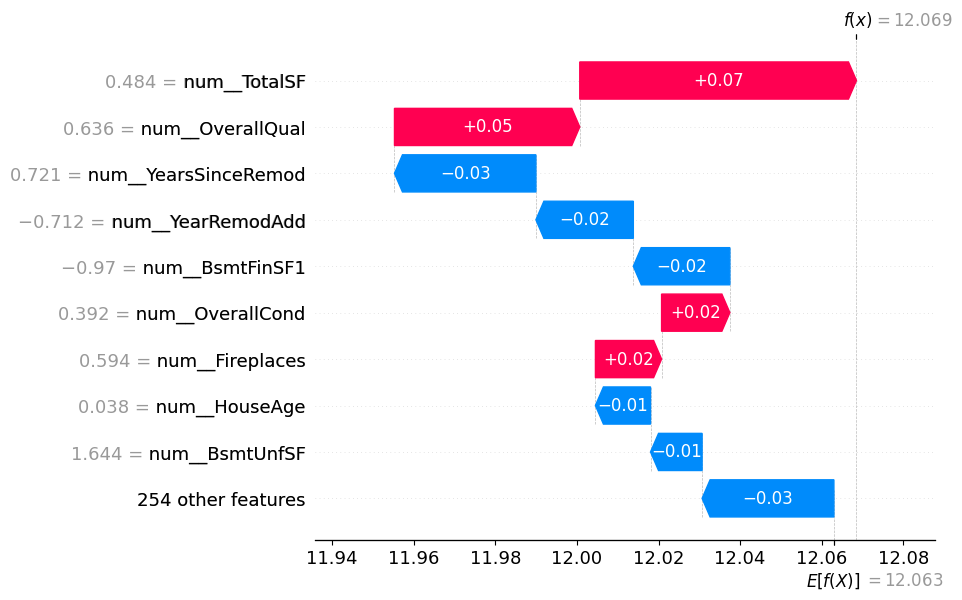

In [45]:
import shap
import matplotlib.pyplot as plt

# This assumes you have already run the code above and have the 'explainer' and 'shap_values' objects.

# --- 1. Select a single instance to explain ---
# We'll pick the first house in the training set as our example.
instance_index = 0

# --- 2. Create the Waterfall Plot ---
print("\n--- SHAP Waterfall Plot for a Single House Prediction ---")
# The shap_values object already contains all the necessary information for the plot.
shap.waterfall_plot(shap_values[instance_index])


# In the end, Lets have a look at our worst predication and the errors in those predictions.

In [47]:
# --- 1. Create a results DataFrame with predictions and errors ---
# Lets take 'y_test_orig' and 'final_xgb_pred' from the evaluation step
error_analysis_df = pd.DataFrame({
    'Actual_SalePrice': y_test_orig,
    'Predicted_SalePrice': final_xgb_pred
})
error_analysis_df['Residual_Error'] = error_analysis_df['Actual_SalePrice'] - error_analysis_df['Predicted_SalePrice']
error_analysis_df['Absolute_Error'] = np.abs(error_analysis_df['Residual_Error'])

# --- 2. Find and display the worst predictions ---
worst_predictions = error_analysis_df.sort_values(by='Absolute_Error', ascending=False)

print("--- Top 5 Worst Predictions (Largest Errors) ---")
display(worst_predictions.head(5))

# We can even merge our findings with the original features to diagnose the "why"
worst_predictions_with_features = df.loc[worst_predictions.head(5).index]
print("\n--- Features of the Houses with the Worst Predictions ---")
display(worst_predictions_with_features[['OverallQual', 'GrLivArea', 'Neighborhood', 'SaleCondition','SalePrice']])

--- Top 5 Worst Predictions (Largest Errors) ---


,Actual_SalePrice,Predicted_SalePrice,Residual_Error,Absolute_Error
691,755000.0,557271.25000,197728.75000,197728.75000
898,611657.0,449109.46875,162547.53125,162547.53125
1046,556581.0,413251.15625,143329.84375,143329.84375
664,423000.0,307475.00000,115525.00000,115525.00000
581,253293.0,365773.56250,-112480.56250,112480.56250



--- Features of the Houses with the Worst Predictions ---


,OverallQual,GrLivArea,Neighborhood,SaleCondition,SalePrice
691,10,4316,NoRidge,Normal,755000
898,9,2364,NridgHt,Partial,611657
1046,9,2868,StoneBr,Partial,556581
664,8,2097,Somerst,Partial,423000
581,8,2042,NridgHt,Partial,253293


#**Summary:**

This project successfully demonstrates a complete, end-to-end workflow for a complex regression problem. By combining deep exploratory analysis, robust data preparation, and systematic model tuning, we were able to build a high-performance XGBoost model that not only predicts house prices accurately but also provides clear, interpretable insights into the key factors that drive the real estate market in Ames.